# Preliminary Operations & Dataset Loading

In [4]:
# Import All Necessary libraries

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats
import numpy as np
from ydata_profiling import ProfileReport

import ipywidgets as widgets
import warnings
from openpyxl import load_workbook
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Visual settings

pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.max_rows', None) # Display all rows
from IPython.display import display # Render dataframes in a more appealing way

In [ ]:
# Load the Datasets

import os
import pandas as pd

# Function to load dataset safely
def load_csv(file_path):
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"⚠️ File not found: {file_path}")
        return None

# Check if running on Kaggle
if os.path.exists('/kaggle/input'):
    base_path = "/kaggle/input/brazilian-ecommerce/"
    marketing_path = "/kaggle/input/marketing-funnel-olist/"
else:
    base_path = "path_to_local_dataset/"
    marketing_path = "path_to_local_marketing_dataset/"

# Load datasets
customers_df = load_csv(base_path + 'olist_customers_dataset.csv')
geolocation_df = load_csv(base_path + 'olist_geolocation_dataset.csv')
order_items_df = load_csv(base_path + 'olist_order_items_dataset.csv')
order_payments_df = load_csv(base_path + 'olist_order_payments_dataset.csv')
order_reviews_df = load_csv(base_path + 'olist_order_reviews_dataset.csv')
orders_df = load_csv(base_path + 'olist_orders_dataset.csv')
products_df = load_csv(base_path + 'olist_products_dataset.csv')
sellers_df = load_csv(base_path + 'olist_sellers_dataset.csv')
product_category_name_translation_df = load_csv(base_path + 'product_category_name_translation.csv')
closed_deals_df = load_csv(marketing_path + 'olist_closed_deals_dataset.csv')
mql_df = load_csv(marketing_path + 'olist_marketing_qualified_leads_dataset.csv')

# Dictionary of loaded DataFrames
dfs = {
    "Customers": customers_df,
    "Geolocation": geolocation_df,
    "Order Items": order_items_df,
    "Order Payments": order_payments_df,
    "Order Reviews": order_reviews_df,
    "Orders": orders_df,
    "Products": products_df,
    "Sellers": sellers_df,
    "Product Category Translation": product_category_name_translation_df,
    "Closed Deals": closed_deals_df,
    "MQL": mql_df,
}

# Display the first few rows of each dataframe
for name, df in dfs.items():
    if df is not None:
        print(f"\n📊 {name}")
        display(df.head())

# Data Cleaning, EDA & Preparation

In [4]:
# Data Info

print('\nCustomers')
customers_df.info()
print('\nGeolocation')
geolocation_df.info()
print('\nOrder Items')
order_items_df.info()
print('\nOrder Payments')
order_payments_df.info()
print('\nOrder Reviews')
order_reviews_df.info()
print('\nOrders')
orders_df.info()
print('\nProducts')
products_df.info()
print('\nSellers')
sellers_df.info()
print('\nProduct Category Name Translation')
product_category_name_translation_df.info()
print('\nClosed Deals')
closed_deals_df.info()
print('\nMQL')
mql_df.info()


Customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB

Geolocation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 3 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 22.9 MB

Order Items
<class 'pandas.cor

In [5]:
# Drop Duplicates
customers_df.drop_duplicates(inplace=True)
geolocation_df.drop_duplicates(inplace=True)
order_items_df.drop_duplicates(inplace=True)
order_payments_df.drop_duplicates(inplace=True)
order_reviews_df.drop_duplicates(inplace=True)
orders_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
sellers_df.drop_duplicates(inplace=True)
closed_deals_df.drop_duplicates(inplace=True)
mql_df.drop_duplicates(inplace=True)

In [6]:
# Category name translation

# Merge products with translation table
products_df = products_df.merge(
    product_category_name_translation_df,
    on='product_category_name',
    how='left'
)

# Replace original column with English translated one
products_df['product_category_name'] = products_df['product_category_name_english']

# Drop the redundant English column
products_df.drop(columns=['product_category_name_english'], inplace=True)

In [7]:
# Data Type Conversion

# Orders Table: Convert date columns to datetime format
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])

# Order Items Table: Convert 'shipping_limit_date' to datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

# Closed Deals Table: Convert 'won_date' to datetime
closed_deals_df['won_date'] = pd.to_datetime(closed_deals_df['won_date'])

# MQL Table: Convert 'first_contact_date' to datetime
mql_df['first_contact_date'] = pd.to_datetime(mql_df['first_contact_date'])

# Convert ZIP code columns to string for consistency
customers_df['customer_zip_code_prefix'] = customers_df['customer_zip_code_prefix'].astype(str)
geolocation_df['geolocation_zip_code_prefix'] = geolocation_df['geolocation_zip_code_prefix'].astype(str)
sellers_df['seller_zip_code_prefix'] = sellers_df['seller_zip_code_prefix'].astype(str)

# Ensure categorical columns are properly typed
products_df['product_category_name'] = products_df['product_category_name'].astype('category')
orders_df['order_status'] = orders_df['order_status'].astype('category')
closed_deals_df['business_type'] = closed_deals_df['business_type'].astype('category')
closed_deals_df['business_segment'] = closed_deals_df['business_segment'].astype('category')
closed_deals_df['lead_type'] = closed_deals_df['lead_type'].astype('category')
closed_deals_df['lead_behaviour_profile'] = closed_deals_df['lead_behaviour_profile'].astype('category')

In [ ]:
# Data Profiling

# Generate profiles for key datasets
customers_profile = ProfileReport(customers_df, title="Customers Table Report")
orders_profile = ProfileReport(orders_df, title="Orders Table Report")
products_profile = ProfileReport(products_df, title="Products Table Report")
sellers_profile = ProfileReport(sellers_df, title="Sellers Table Report")
payments_profile = ProfileReport(order_payments_df, title="Payments Table Report")
Geolocation_profile = ProfileReport(geolocation_df, title="Geolocation Table Report")
Order_Items_profile = ProfileReport(order_items_df, title="Order Items Table Report")
Order_Reviews_profile = ProfileReport(order_reviews_df, title="Order Reviews Table Report")
Closed_Deals_profile = ProfileReport(closed_deals_df, title="Closed Deals Table Report")
MQL_profile = ProfileReport(mql_df, title="MQL Table Report")

# Display or save the reports
customers_profile.to_file("customers_profile_report.html")  # Generate and save an HTML report file
orders_profile.to_file("orders_profile_report.html")
products_profile.to_file("products_profile_report.html")
sellers_profile.to_file("sellers_profile_report.html")
payments_profile.to_file("payments_profile_report.html")
Geolocation_profile.to_file("geolocation_profile_report.html")
Order_Items_profile.to_file("order_items_profile_report.html")
Order_Reviews_profile.to_file("order_reviews_profile_report.html")
Closed_Deals_profile.to_file("closed_deals_profile_report.html")
MQL_profile.to_file("mql_profile_report.html")

In [8]:
# Custom function describex()

from scipy.stats import skew, kurtosis
import pandas as pd

def describex(data):
    numeric_columns = data.select_dtypes(include=['number']).columns
    non_numeric_columns = data.select_dtypes(exclude=['number']).columns

    numeric_stats = pd.DataFrame()
    non_numeric_stats = pd.DataFrame()

    for column in numeric_columns:
        numeric_data = data[column]
        numeric_stats[column] = [
            numeric_data.count(),  # Count
            numeric_data.notnull().sum(),  # Non-Null
            numeric_data.isnull().sum(),  # Null
            numeric_data.mean(),  # Mean
            numeric_data.median(),  # Median
            numeric_data.mode()[0] if not numeric_data.mode().empty else None,  # Mode
            numeric_data.std(),  # Std
            numeric_data.var(),  # Var
            skew(numeric_data),  # Skew
            kurtosis(numeric_data),  # Kurt
            numeric_data.min(),  # Min
            numeric_data.quantile(0.25),  # 25th Percentile
            numeric_data.quantile(0.50),  # 50th Percentile
            numeric_data.quantile(0.75),  # 75th Percentile
            numeric_data.max(),  # Max
            numeric_data.max() - numeric_data.min(),  # Range
            ((numeric_data < (numeric_data.quantile(0.25) - 1.5 * (numeric_data.quantile(0.75) - numeric_data.quantile(0.25)))) | 
             (numeric_data > (numeric_data.quantile(0.75) + 1.5 * (numeric_data.quantile(0.75) - numeric_data.quantile(0.25))))).sum(),  # Outliers
            numeric_data.sub(numeric_data.mean()).div(numeric_data.std()).abs().mean()  # Z-Score
        ]

    numeric_stats.index = ['Count', 'Non-Null', 'Null', 'Mean', 'Median', 'Mode', 'Std', 'Var', 'Skew', 'Kurt', 'Min', '25%', '50%', '75%', 'Max', 'Range', 'Outliers', 'Z-Score']
    numeric_stats = numeric_stats.T

    for column in non_numeric_columns:
        non_numeric_data = data[column]
        non_numeric_stats[column] = [
            non_numeric_data.count(),  # Count
            non_numeric_data.notnull().sum(),  # Non-Null
            non_numeric_data.isnull().sum(),  # Null
            non_numeric_data.nunique(),  # Unique
            non_numeric_data.mode()[0] if not non_numeric_data.mode().empty else None,  # Top
            non_numeric_data.value_counts().iloc[0] if not non_numeric_data.value_counts().empty else None  # Freq
        ]

    non_numeric_stats.index = ['Count', 'Non-Null', 'Null', 'Unique', 'Top', 'Freq']
    non_numeric_stats = non_numeric_stats.T

    return numeric_stats, non_numeric_stats

print('Function loaded!')

Function loaded!


In [9]:
# Descriptive statistics
numeric_stats_customers, non_numeric_stats_customers = describex(customers_df)
numeric_stats_geolocation, non_numeric_stats_geolocation = describex(geolocation_df)
numeric_stats_order_items, non_numeric_stats_order_items = describex(order_items_df)
numeric_stats_order_payments, non_numeric_stats_order_payments = describex(order_payments_df)
numeric_stats_order_reviews, non_numeric_stats_order_reviews = describex(order_reviews_df)
numeric_stats_orders, non_numeric_stats_orders = describex(orders_df)
numeric_stats_products, non_numeric_stats_products = describex(products_df)
numeric_stats_sellers, non_numeric_stats_sellers = describex(sellers_df)
numeric_stats_product_category_name_translation, non_numeric_stats_product_category_name_translation = describex(product_category_name_translation_df)
numeric_stats_closed_deals, non_numeric_stats_closed_deals = describex(closed_deals_df)
numeric_stats_mql, non_numeric_stats_mql = describex(mql_df)

In [10]:
# Numeric stats

print('\nCustomers')
display(numeric_stats_customers)
print('\nGeolocation')
display(numeric_stats_geolocation)
print('\nOrder Items')
display(numeric_stats_order_items)
print('\nOrder Payments')
display(numeric_stats_order_payments)
print('\nOrder Reviews')
display(numeric_stats_order_reviews)
print('\nOrders')
display(numeric_stats_orders)
print('\nProducts')
display(numeric_stats_products)
print('\nSellers')
display(numeric_stats_sellers)
print('\nProduct Category Name Translation')
display(numeric_stats_product_category_name_translation)
print('\nClosed Deals')
display(numeric_stats_closed_deals)
print('\nMQL')
display(numeric_stats_mql)


Customers


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score



Geolocation


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score
geolocation_lat,720154.0,720154.0,0.0,-20.974809,-22.861875,-20.316044,5.918866,35.032972,1.462826,2.402305,-36.605374,-23.601862,-22.861875,-19.916325,45.065933,81.671308,128772.0,0.704586
geolocation_lng,720154.0,720154.0,0.0,-46.452045,-46.645727,-41.322001,4.419726,19.533978,-0.046136,4.954164,-101.466766,-48.912225,-46.645727,-43.786507,121.105394,222.572160,27451.0,0.715838



Order Items


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score
order_item_id,112650.0,112650.0,0.0,1.197834,1.00,1.0,0.705124,0.497200,7.580255,103.852698,1.00,1.00,1.00,1.00,21.00,20.00,13984.0,0.491475
product_price,112650.0,112650.0,0.0,120.653739,74.99,59.9,183.633928,33721.419531,7.923103,120.822882,0.85,39.90,74.99,134.90,6735.00,6734.15,8427.0,0.490539
freight_value,112650.0,112650.0,0.0,19.990320,16.26,15.1,15.806405,249.842452,5.639795,59.785546,0.00,13.08,16.26,21.15,409.68,409.68,12134.0,0.547561



Order Payments


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score
payment_installments,103886.0,103886.0,0.0,2.853349,1.0,1.0,2.687051,7.220241,1.655050,2.549867,0.0,1.00,1.0,4.0000,24.00,24.00,6313.0,0.773674
payment_value,103886.0,103886.0,0.0,154.100380,100.0,50.0,217.494064,47303.667816,9.253876,241.816745,0.0,56.79,100.0,171.8375,13664.08,13664.08,7981.0,0.501928
payment_sequential,103886.0,103886.0,0.0,1.092679,1.0,1.0,0.706584,0.499261,16.179831,370.575915,1.0,1.00,1.0,1.0000,29.00,28.00,4526.0,0.250900



Order Reviews


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score
review_score,99224.0,99224.0,0.0,4.086421,5.0,5.0,1.347579,1.81597,-1.364365,0.507567,1.0,4.0,5.0,5.0,5.0,4.0,14575.0,0.783379



Orders


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score



Products


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score
product_name_lenght,32341.0,32341.0,610.0,48.476949,51.0,60.0,10.245741,1.049752e+02,NaN,NaN,5.0,42.0,51.0,57.0,76.0,71.0,290.0,0.820470
product_description_lenght,32341.0,32341.0,610.0,771.495285,595.0,404.0,635.115225,4.033713e+05,NaN,NaN,4.0,339.0,595.0,972.0,3992.0,3988.0,2078.0,0.719201
product_photos_qty,32341.0,32341.0,610.0,2.188986,1.0,1.0,1.736766,3.016355e+00,NaN,NaN,1.0,1.0,1.0,3.0,20.0,19.0,849.0,0.740227
product_weight_g,32949.0,32949.0,2.0,2276.472488,700.0,200.0,4282.038731,1.833586e+07,NaN,NaN,0.0,300.0,700.0,1900.0,40425.0,40425.0,4551.0,0.588428
product_length_cm,32949.0,32949.0,2.0,30.815078,25.0,16.0,16.914458,2.860989e+02,NaN,NaN,7.0,18.0,25.0,38.0,105.0,98.0,1380.0,0.753627
product_height_cm,32949.0,32949.0,2.0,16.937661,13.0,10.0,13.637554,1.859829e+02,NaN,NaN,2.0,8.0,13.0,21.0,105.0,103.0,1892.0,0.706905
product_width_cm,32949.0,32949.0,2.0,23.196728,20.0,11.0,12.079047,1.459034e+02,NaN,NaN,6.0,15.0,20.0,30.0,118.0,112.0,912.0,0.770683



Sellers


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score



Product Category Name Translation


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score



Closed Deals


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score



MQL


,Count,Non-Null,Null,Mean,Median,Mode,Std,Var,Skew,Kurt,Min,25%,50%,75%,Max,Range,Outliers,Z-Score


In [11]:
# Non-numeric stats
print('\nCustomers')
display(non_numeric_stats_customers)
print('\nGeolocation')
display(non_numeric_stats_geolocation)
print('\nOrder Items')
display(non_numeric_stats_order_items)
print('\nOrder Payments')
display(non_numeric_stats_order_payments)
print('\nOrder Reviews')
display(non_numeric_stats_order_reviews)
print('\nOrders')
display(non_numeric_stats_orders)
print('\nProducts')
display(non_numeric_stats_products)
print('\nSellers')
display(non_numeric_stats_sellers)
print('\nProduct Category Name Translation')
display(non_numeric_stats_product_category_name_translation)
print('\nClosed Deals')
display(non_numeric_stats_closed_deals)
print('\nMQL')
display(non_numeric_stats_mql)


Customers


,Count,Non-Null,Null,Unique,Top,Freq
customer_id,99441,99441,0,99441,00012a2ce6f8dcda20d059ce98491703,1
customer_zip_code_prefix,99441,99441,0,14994,22790,142
customer_city,99441,99441,0,4119,sao paulo,15540
customer_state,99441,99441,0,27,SP,41746



Geolocation


,Count,Non-Null,Null,Unique,Top,Freq
geolocation_zip_code_prefix,720154,720154,0,19015,38400,746



Order Items


,Count,Non-Null,Null,Unique,Top,Freq
order_id,112650,112650,0,98666,8272b63d03f5f79c56e9e4120aec44ef,21
product_id,112650,112650,0,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527
seller_id,112650,112650,0,3095,6560211a19b47992c3666cc44a7e94c0,2033
shipping_limit_date,112650,112650,0,93318,2017-07-21 18:25:23,21



Order Payments


,Count,Non-Null,Null,Unique,Top,Freq
order_id,103886,103886,0,99440,fa65dad1b0e818e3ccc5cb0e39231352,29
payment_type,103886,103886,0,5,credit_card,76795



Order Reviews


,Count,Non-Null,Null,Unique,Top,Freq
review_id,99224,99224,0,98410,08528f70f579f0c830189efc523d2182,3
order_id,99224,99224,0,98673,03c939fd7fd3b38f8485a0f95798f1f6,3
review_creation_date,99224,99224,0,636,2017-12-19 00:00:00,463
review_answer_timestamp,99224,99224,0,98248,2017-06-15 23:21:05,4



Orders


,Count,Non-Null,Null,Unique,Top,Freq
order_id,99441,99441,0,99441,00010242fe8c5a6d1ba2dd792cb16214,1
customer_id,99441,99441,0,99441,00012a2ce6f8dcda20d059ce98491703,1
order_status,99441,99441,0,8,delivered,96478
order_purchase_timestamp,99441,99441,0,98875,2017-11-20 10:59:08,3
order_approved_at,99281,99281,160,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,97658,1783,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,96476,2965,95664,2016-10-27 17:32:07,3
order_estimated_delivery_date,99441,99441,0,459,2017-12-20 00:00:00,522



Products


,Count,Non-Null,Null,Unique,Top,Freq
product_id,32951,32951,0,32951,00066f42aeeb9f3007548bb9d3f33c38,1
product_category_name,32328,32328,623,71,bed_bath_table,3029



Sellers


,Count,Non-Null,Null,Unique,Top,Freq
seller_id,3095,3095,0,3095,0015a82c2db000af6aaaf3ae2ecb0532,1
seller_zip_code_prefix,3095,3095,0,2246,14940,49
seller_city,3095,3095,0,611,sao paulo,694
seller_state,3095,3095,0,23,SP,1849



Product Category Name Translation


,Count,Non-Null,Null,Unique,Top,Freq
product_category_name,71,71,0,71,agro_industria_e_comercio,1
product_category_name_english,71,71,0,71,agro_industry_and_commerce,1



Closed Deals


,Count,Non-Null,Null,Unique,Top,Freq
mql_id,842,842,0,842,000dd3543ac84d906eae52e7c779bb2a,1
seller_id,842,842,0,842,00065220becb8785e2cf78355eb9bf68,1
sdr_id,842,842,0,32,4b339f9567d060bcea4f5136b9f5949e,140
sr_id,842,842,0,22,4ef15afb4b2723d8f3d81e51ec7afefe,133
won_date,842,842,0,824,2018-05-04 03:00:00,6
business_type,832,832,10,3,reseller,587
business_segment,841,841,1,33,home_decor,105
lead_type,836,836,6,8,online_medium,332
lead_behaviour_profile,665,665,177,9,cat,407



MQL


,Count,Non-Null,Null,Unique,Top,Freq
mql_id,8000,8000,0,8000,0002ac0d783338cfeab0b2bdbd872cda,1
landing_page_id,8000,8000,0,495,b76ef37428e6799c421989521c0e5077,912
first_contact_date,8000,8000,0,336,2018-05-02 00:00:00,93
origin,7940,7940,60,10,organic_search,2296


In [12]:
# 1. Handling Missing Values in Products Table

# Change datatype of replaced columns to object (from categorical) and add the new category 'Unkown' to the new categorical variable
# products_df['product_category_name'] = products_df['product_category_name'].astype(object)
# products_df.loc[products_df['product_category_name'].isna(), 'product_category_name'] = 'Unknown'

# Add 'Unknown' as a category
products_df['product_category_name'] = products_df['product_category_name'].cat.add_categories(['Unknown'])

# Replace NaN with 'Unknown'
products_df['product_category_name'] = products_df['product_category_name'].fillna('Unknown')


# Fill numerical columns in products_df with the median
products_df['product_name_lenght'] = products_df['product_name_lenght'].fillna(products_df['product_name_lenght'].median())
products_df['product_description_lenght'] = products_df['product_description_lenght'].fillna(products_df['product_description_lenght'].median())
products_df['product_photos_qty'] = products_df['product_photos_qty'].fillna(products_df['product_photos_qty'].median())

# Drop rows with missing product dimension values
products_df.dropna(subset=['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)

Consecutive null streaks in order_approved_at:
order_approved_at
1    156
2      4
Name: count, dtype: int64


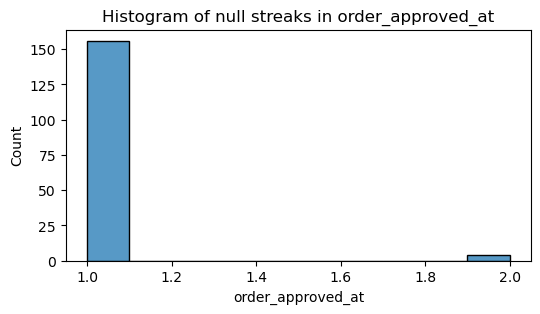

Consecutive null streaks in order_delivered_carrier_date:
order_delivered_carrier_date
1    1702
2      78
3       3
Name: count, dtype: int64


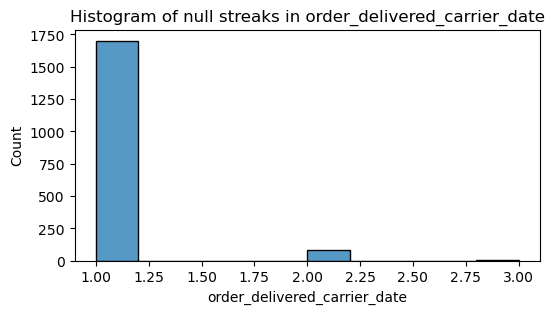

Consecutive null streaks in order_delivered_customer_date:
order_delivered_customer_date
1    2799
2     154
3      12
Name: count, dtype: int64


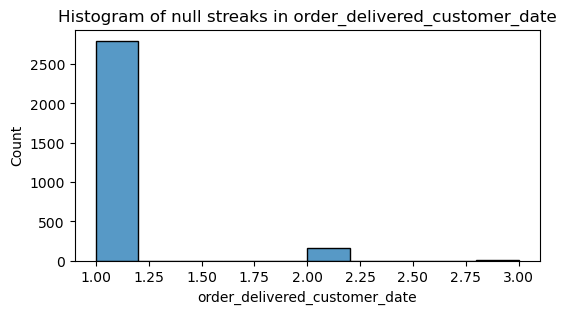

In [13]:
# Function to count streaks of missing values
def count_null_streaks(column):
    nulls = orders_df[column].isnull().astype(int)
    streaks = nulls.groupby((nulls != nulls.shift()).cumsum()).transform('size')
    
    # Display streaks > 1
    consecutive_nulls = streaks[nulls == 1]
    print(f"Consecutive null streaks in {column}:")
    print(consecutive_nulls.value_counts())
    
    # Visualize streaks
    plt.figure(figsize=(6, 3))
    sns.histplot(streaks[nulls == 1], bins=10, kde=False)
    plt.title(f"Histogram of null streaks in {column}")
    plt.show()

# Apply to the specified columns
for col in ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']:
    count_null_streaks(col)

In [14]:
# 2. Handling Missing Values in Orders Table

# Forward fill for 'order_approved_at' based on 'order_purchase_timestamp'
orders_df['order_approved_at'] = orders_df['order_approved_at'].fillna(orders_df['order_purchase_timestamp'])

# Fill 'order_delivered_customer_date' with the estimated delivery date if missing
orders_df['order_delivered_customer_date'] = orders_df['order_delivered_customer_date'].fillna(orders_df['order_estimated_delivery_date'])

# Use backward fill for 'order_delivered_carrier_date'
orders_df['order_delivered_carrier_date'] = orders_df['order_delivered_carrier_date'].bfill()

In [15]:
# 3. Handling Missing Values in Closed Deals Table

# Add 'Unknown' as a category
closed_deals_df['lead_behaviour_profile'] = closed_deals_df['lead_behaviour_profile'].cat.add_categories(['Unknown'])

# Fill missing values in'lead_behaviour_profile' with 'Unknown'
closed_deals_df['lead_behaviour_profile'] = closed_deals_df['lead_behaviour_profile'].fillna('Unknown')


# Add a new category 'Unknown'
for col in ['business_type', 'business_segment', 'lead_type']:
    closed_deals_df[col] = closed_deals_df[col].cat.add_categories(['Unknown'])

# Fill missing values in categorical columns with 'Unknown'
for col in ['business_type', 'business_segment', 'lead_type']:
    closed_deals_df[col] = closed_deals_df[col].fillna('Unknown')

In [16]:
# 4. Handling Missing Values in MQL Table

# Fill 'origin' with 'Unknown'
mql_df['origin'] = mql_df['origin'].fillna('Unknown')

In [17]:
# Data merging

# Start with orders_df
merged_df = orders_df.copy()

# Merge customers
merged_df = merged_df.merge(customers_df, on='customer_id', how='left')

# Merge order items
merged_df = merged_df.merge(order_items_df, on='order_id', how='left')

# Merge payments
merged_df = merged_df.merge(order_payments_df, on='order_id', how='left')

# Merge reviews
merged_df = merged_df.merge(order_reviews_df, on='order_id', how='left')

# Merge products
merged_df = merged_df.merge(products_df, on='product_id', how='left')

# Merge sellers
merged_df = merged_df.merge(sellers_df, on='seller_id', how='left')

# Final merged dataframe
print(f"Final Merged Dataframe Shape: {merged_df.shape}")

Final Merged Dataframe Shape: (119143, 36)


In [18]:
# Optimized function for datatype conversion and memory reduction
def optimize_dataframe(df, datetime_cols=None, exclude_category_cols=None, force_category_cols=None):
    """
    Optimize a dataframe by converting datatypes.
    - Converts specified columns to datetime.
    - Converts object columns to category, excluding specified columns.
    - Downcasts numerical columns.
    - Forces specific columns to category if specified.
    
    Parameters:
        df (pd.DataFrame): The dataframe to optimize.
        datetime_cols (list): List of columns to convert to datetime.
        exclude_category_cols (list): List of object columns to exclude from category conversion.
        force_category_cols (list): List of columns to forcefully convert to category.
    """
    datetime_cols = datetime_cols or []
    exclude_category_cols = exclude_category_cols or []
    force_category_cols = force_category_cols or []

    for col in df.columns:
        if col in datetime_cols:  # Convert to datetime
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
            except ValueError:
                print(f"Warning: Could not convert {col} to datetime.")
        elif col in force_category_cols:  # Force specific columns to category
            df[col] = df[col].astype('category')
        elif df[col].dtype == 'object' and col not in exclude_category_cols:  # Convert object to category
            df[col] = df[col].astype('category')
        elif df[col].dtype == 'int64':  # Downcast integers
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':  # Downcast floats
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# Define datetime columns for each dataframe
datetime_columns = {
    'order_reviews_df': ['review_creation_date', 'review_answer_timestamp'],
    'orders_df': ['order_purchase_timestamp', 'order_approved_at', 
                  'order_delivered_carrier_date', 'order_delivered_customer_date', 
                  'order_estimated_delivery_date'],
    'mql_df': ['first_contact_date'],
    'closed_deals_df': ['won_date'],
    'merged_df': ['order_purchase_timestamp', 'order_approved_at', 
                  'order_delivered_carrier_date', 'order_delivered_customer_date', 
                  'order_estimated_delivery_date', 'review_creation_date', 
                  'review_answer_timestamp', 'shipping_limit_date', 'won_date', 'first_contact_date']
}

# Define columns to exclude from category conversion
exclude_from_category = {
    'order_reviews_df': ['review_id'],
    'orders_df': ['order_id', 'customer_id'],
    'products_df': ['product_id'],
    'customers_df': ['customer_id'],
    'sellers_df': ['seller_id'],
    'merged_df': ['order_id', 'customer_id', 'product_id', 'seller_id', 'review_id', 'mql_id']
}

# Force specific columns to category
force_category_columns = {
    'order_items_df': ['order_item_id'],  # Force order_item_id to category
    'merged_df': ['order_item_id']        # Ensure consistency in the merged dataframe
}

# List of all dataframes
dataframes = {
    'order_reviews_df': order_reviews_df,
    'orders_df': orders_df,
    'order_items_df': order_items_df,
    'order_payments_df': order_payments_df,
    'products_df': products_df,
    'customers_df': customers_df,
    'sellers_df': sellers_df,
    'geolocation_df': geolocation_df,
    'closed_deals_df': closed_deals_df,
    'mql_df': mql_df,
    'product_category_name_translation_df': product_category_name_translation_df,
    'merged_df': merged_df
}

# Apply optimization to all dataframes
optimized_dataframes = {}
for name, df in dataframes.items():
    print(f"Optimizing {name}...")
    optimized_dataframes[name] = optimize_dataframe(
        df, 
        datetime_cols=datetime_columns.get(name, []), 
        exclude_category_cols=exclude_from_category.get(name, []),
        force_category_cols=force_category_columns.get(name, [])
    )

# Unpack optimized dataframes back to variables
(order_reviews_df, orders_df, order_items_df, order_payments_df, 
 products_df, customers_df, sellers_df, geolocation_df, 
 closed_deals_df, mql_df, product_category_name_translation_df, merged_df) = optimized_dataframes.values()

# Check memory usage for verification
for name, df in optimized_dataframes.items():
    print(f"{name} memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Optimizing order_reviews_df...
Optimizing orders_df...
Optimizing order_items_df...
Optimizing order_payments_df...
Optimizing products_df...
Optimizing customers_df...
Optimizing sellers_df...
Optimizing geolocation_df...
Optimizing closed_deals_df...
Optimizing mql_df...
Optimizing product_category_name_translation_df...
Optimizing merged_df...
order_reviews_df memory usage: 19.29 MB
orders_df memory usage: 19.25 MB
order_items_df memory usage: 16.39 MB
order_payments_df memory usage: 10.79 MB
products_df memory usage: 3.71 MB
customers_df memory usage: 9.79 MB
sellers_df memory usage: 0.48 MB
geolocation_df memory usage: 13.84 MB
closed_deals_df memory usage: 0.22 MB
mql_df memory usage: 1.02 MB
product_category_name_translation_df memory usage: 0.01 MB
merged_df memory usage: 62.54 MB


In [19]:
# Data Info

print('\nCustomers')
customers_df.info()
print('\nGeolocation')
geolocation_df.info()
print('\nOrder Items')
order_items_df.info()
print('\nOrder Payments')
order_payments_df.info()
print('\nOrder Reviews')
order_reviews_df.info()
print('\nOrders')
orders_df.info()
print('\nProducts')
products_df.info()
print('\nSellers')
sellers_df.info()
print('\nProduct Category Name Translation')
product_category_name_translation_df.info()
print('\nClosed Deals')
closed_deals_df.info()
print('\nMQL')
mql_df.info()


Customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_id               99441 non-null  object  
 1   customer_zip_code_prefix  99441 non-null  category
 2   customer_city             99441 non-null  category
 3   customer_state            99441 non-null  category
dtypes: category(3), object(1)
memory usage: 2.0+ MB

Geolocation
<class 'pandas.core.frame.DataFrame'>
Index: 720154 entries, 0 to 1000161
Data columns (total 3 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   geolocation_zip_code_prefix  720154 non-null  category
 1   geolocation_lat              720154 non-null  float32 
 2   geolocation_lng              720154 non-null  float32 
dtypes: category(1), float32(2)
memory usage: 13.0 MB

Order Items
<class

In [20]:
# Merged Dataframe Info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  category      
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              119143 non-null  datetime64[ns]
 5   order_delivered_carrier_date   119143 non-null  datetime64[ns]
 6   order_delivered_customer_date  119143 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   customer_zip_code_prefix       119143 non-null  category      
 9   customer_city                  119143 non-null  category      
 10  customer_state                 119143 non-null  category      
 11  

In [21]:
# Check for duplicates in merged_df based on order_id
duplicate_orders = merged_df[merged_df.duplicated(subset=['order_id'], keep=False)]
print(f"Number of duplicate orders: {len(duplicate_orders)}")

# Drop duplicates based on order_id to ensure each order appears only once
merged_df = merged_df.drop_duplicates(subset=['order_id'])

# Check the total number of records after dropping duplicates
print(f"Total records after removing duplicates by order_id: {len(merged_df)}")

Number of duplicate orders: 32649
Total records after removing duplicates by order_id: 99441


# Analysis

## Sales & Profitability

Monthly Sales Metrics:


,Month,Total Sales (BRL),Total Orders,Monthly Sales Growth (%)
0,2016-09-01,144.48,4,0.00%
1,2016-10-01,"45,160.59",324,31157.33%
2,2016-12-01,10.90,1,-99.98%
3,2017-01-01,"108,361.22",800,994039.62%
4,2017-02-01,"229,733.92",1780,112.01%
5,2017-03-01,"346,994.22",2682,51.04%
6,2017-04-01,"332,505.91",2404,-4.18%
7,2017-05-01,"465,799.00",3700,40.09%
8,2017-06-01,"405,267.25",3245,-13.00%
9,2017-07-01,"454,179.53",4026,12.07%


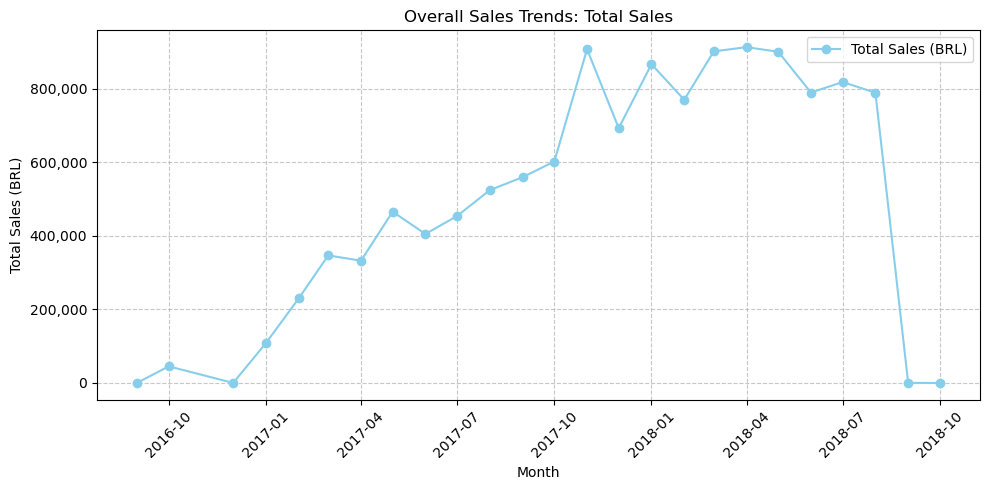

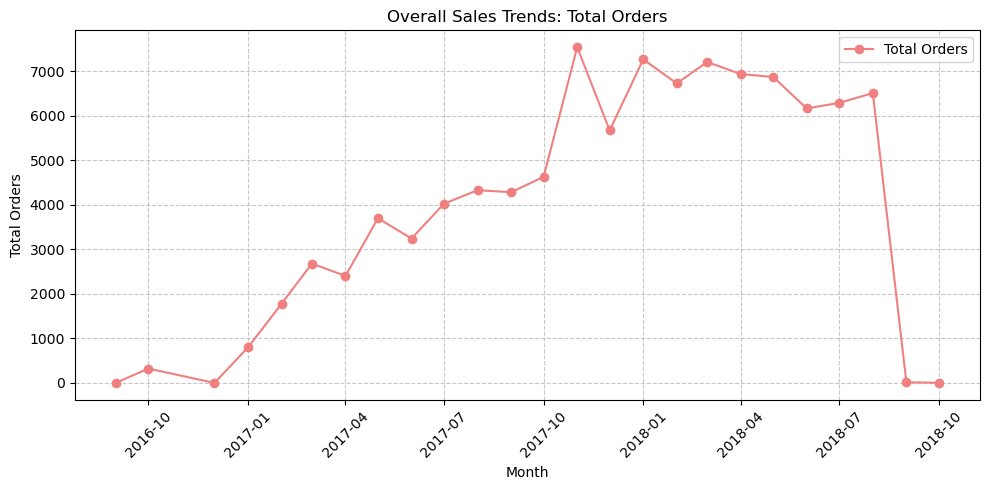

In [23]:
# Sales Trends Analysis

# Ensure merged_df is not a slice, and use .loc explicitly
merged_df = merged_df.copy()

# Group sales data by month
merged_df.loc[:, 'order_purchase_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = merged_df.groupby('order_purchase_month').agg(
    total_sales_brl=('product_price', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

# Calculate monthly sales growth
monthly_sales['monthly_sales_growth'] = monthly_sales['total_sales_brl'].pct_change() * 100

# Replace NaN in the first row of Monthly Sales Growth (%) with 0
monthly_sales.fillna({'monthly_sales_growth': 0}, inplace=True)

# Convert period to datetime for plotting
monthly_sales['order_purchase_month'] = monthly_sales['order_purchase_month'].dt.to_timestamp()

# Rename columns for better readability
monthly_sales.rename(columns={
    'order_purchase_month': 'Month',
    'total_sales_brl': 'Total Sales (BRL)',
    'total_orders': 'Total Orders',
    'monthly_sales_growth': 'Monthly Sales Growth (%)'
}, inplace=True)

# Format numbers for readability
monthly_sales['Total Sales (BRL)'] = monthly_sales['Total Sales (BRL)'].map('{:,.2f}'.format)
monthly_sales['Monthly Sales Growth (%)'] = monthly_sales['Monthly Sales Growth (%)'].map('{:.2f}%'.format)

# Display updated monthly sales table
print("Monthly Sales Metrics:")
display(monthly_sales)

import matplotlib.ticker as mtick

# Plot total sales trends with proper formatting
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['Month'], monthly_sales['Total Sales (BRL)'].str.replace(',', '').astype(float),
         color='skyblue', marker='o', label='Total Sales (BRL)')
plt.title('Overall Sales Trends: Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales (BRL)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()

# Format y-axis to remove scientific notation
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()


# Plot total orders trends
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['Month'], monthly_sales['Total Orders'], color='lightcoral', marker='o', label='Total Orders')
plt.title('Overall Sales Trends: Total Orders')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Sales Trends Analysis

**Key Insights:**
- **Steady Growth:** Monthly sales and order volumes exhibit a significant upward trend from January 2017 to November 2017, peaking in November 2017 with **907,866.31 BRL** in sales and **7,544 orders**, likely due to seasonal or promotional activities.
- **Volatility:** Sales growth shows intermittent dips, particularly in **April 2017 (-4.18%)**, **December 2017 (-23.65%)**, and **February 2018 (-11.19%)**, indicating potential seasonality or external disruptions.
- **Decline Post-Peak:** After November 2017, sales and orders decline slightly but stabilize between **June 2018 and August 2018**, averaging **~800,000 BRL** in sales and **~6,500 orders**.
- **Outliers:** Unusually low sales in **September 2016, December 2016, and October 2018** suggest data anomalies or operational irregularities during these months.

**Overall Observation:** Sales demonstrate a robust growth trajectory, with occasional fluctuations hinting at seasonal effects or operational challenges. Strategic planning during high-growth months could maximize revenue.

,State,Total Sales (BRL),Total Orders
25,SP,"4,746,619.00",41746
18,RJ,"1,662,485.00",12852
10,MG,"1,457,640.12",11635
22,RS,"684,857.56",5466
17,PR,"619,171.00",5045
23,SC,"475,541.00",3637
4,BA,"464,448.72",3380
6,DF,"278,785.69",2140
8,GO,"263,419.53",2020
7,ES,"252,477.55",2033


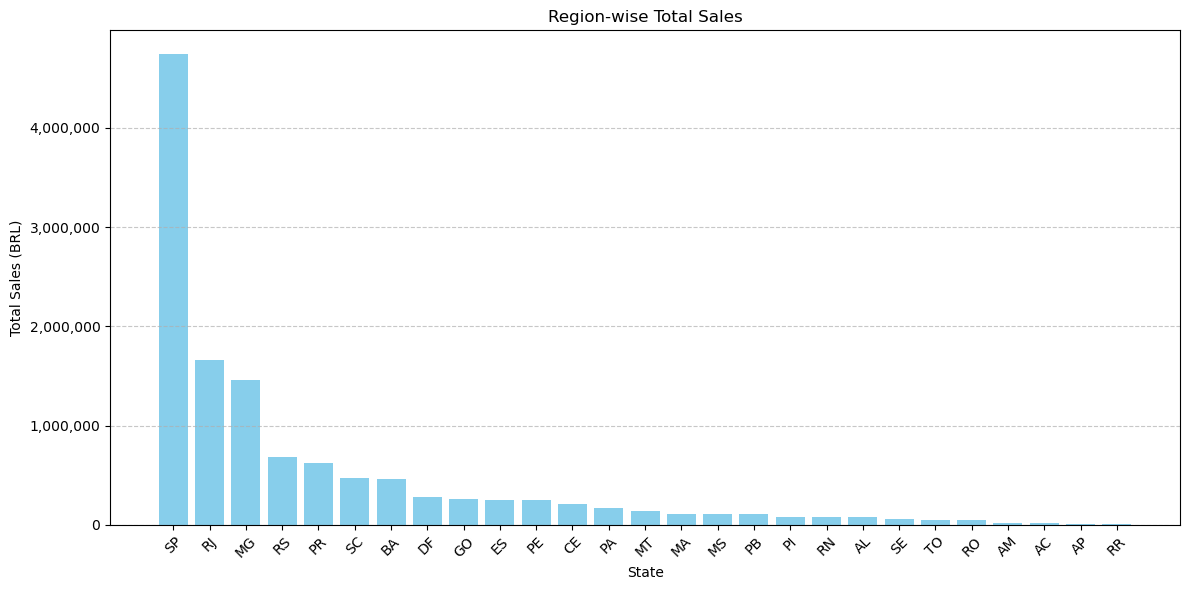

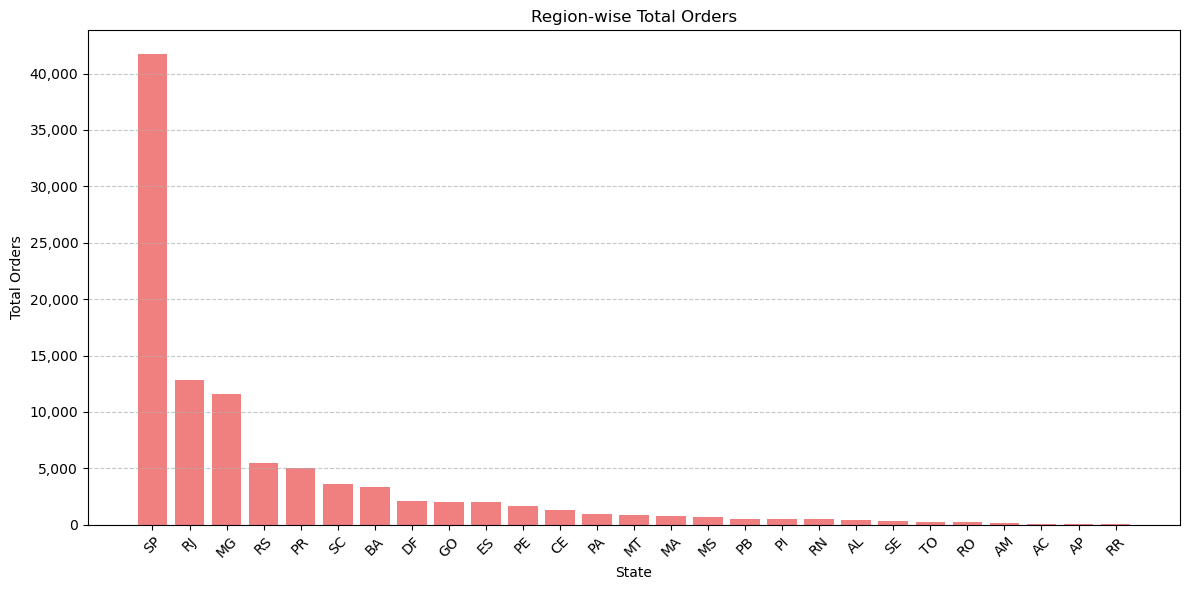

In [24]:
# Region-wise Sales Analysis

# Aggregate sales and order data by customer state
region_sales = merged_df.groupby('customer_state', observed=False).agg(
    total_sales=('product_price', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

# Sort by total sales
region_sales = region_sales.sort_values(by='total_sales', ascending=False)

# Rename columns for clarity
region_sales.columns = ['State', 'Total Sales (BRL)', 'Total Orders']

# Format numbers for readability in the table
region_sales['Total Sales (BRL)'] = region_sales['Total Sales (BRL)'].map('{:,.2f}'.format)

# Display the table (quantified metrics)
display(region_sales)


# Plot total sales by region
plt.figure(figsize=(12, 6))
plt.bar(region_sales['State'], region_sales['Total Sales (BRL)'].str.replace(',', '').astype(float), color='skyblue')
plt.title('Region-wise Total Sales')
plt.xlabel('State')
plt.ylabel('Total Sales (BRL)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis with proper notation
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()


# Plot total orders by region
plt.figure(figsize=(12, 6))
plt.bar(region_sales['State'], region_sales['Total Orders'], color='lightcoral')
plt.title('Region-wise Total Orders')
plt.xlabel('State')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

#### Region-wise Sales Analysis

**Key Insights:**
- **Top Performers:** The state of **São Paulo (SP)** dominates with **4.75M BRL** in sales and **41,746 orders**, contributing significantly to the overall revenue.
- **High-Performing Regions:** **Rio de Janeiro (RJ)** and **Minas Gerais (MG)** rank second and third, with **1.66M BRL** and **1.46M BRL** in sales, respectively, indicating strong customer bases in these states.
- **Mid-Tier States:** States like **Rio Grande do Sul (RS)**, **Paraná (PR)**, and **Santa Catarina (SC)** contribute moderately, each generating over **450K BRL** in sales with **3,600+ orders**.
- **Low Contribution States:** States such as **Roraima (RR)**, **Amapá (AP)**, and **Acre (AC)** exhibit minimal sales and orders, collectively contributing less than **50K BRL**.
- **Regional Disparity:** Sales are heavily concentrated in **SP, RJ, and MG**, while northern and less urbanized regions show significantly lower activity.

**Overall Observation:** Sales distribution highlights a strong regional concentration in Brazil's southeastern states, indicating the need for targeted marketing strategies to tap into underperforming regions.

Average Order Value (AOV) Summary


,Total Orders,Total Sales (BRL),Average Order Value (BRL)
0,99441,"14,421,640.00",145.03


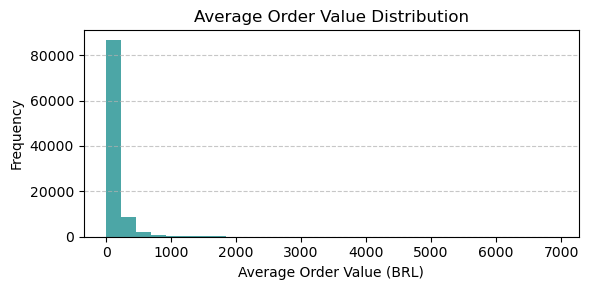

In [25]:
# Average Order Value (AOV) Analysis

# Calculate Average Order Value (AOV)
aov_df = merged_df.groupby('order_id').agg(
    total_order_value=('product_price', 'sum'),
    total_freight=('freight_value', 'sum')
).reset_index()

# Add a column for AOV
aov_df['average_order_value'] = aov_df['total_order_value'] + aov_df['total_freight']

# Aggregate AOV metrics
aov_summary = pd.DataFrame({
    'Total Orders': [len(aov_df)],
    'Total Sales (BRL)': [aov_df['average_order_value'].sum()],
    'Average Order Value (BRL)': [aov_df['average_order_value'].mean()]
})

# Format numbers for readability
aov_summary['Total Sales (BRL)'] = aov_summary['Total Sales (BRL)'].map('{:,.2f}'.format)
aov_summary['Average Order Value (BRL)'] = aov_summary['Average Order Value (BRL)'].map('{:,.2f}'.format)

# Display the metrics
print('Average Order Value (AOV) Summary')
display(aov_summary)

# Plot AOV distribution
plt.figure(figsize=(6, 3))
plt.hist(aov_df['average_order_value'], bins=30, color='teal', alpha=0.7)
plt.title('Average Order Value Distribution')
plt.xlabel('Average Order Value (BRL)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Average Order Value (AOV)

**Key Insights:**
- **Average Order Value (AOV):** The AOV stands at **145.03 BRL**, calculated from **99,441 total orders** generating **14.42M BRL** in total sales.
- **Revenue Efficiency:** This metric reflects the average revenue generated per order, providing a baseline for evaluating the effectiveness of sales strategies and pricing models.

**Overall Observation:** Maintaining or increasing the AOV through strategies like upselling, bundling, or targeted promotions could further enhance revenue without requiring a proportional increase in order volume.

Seasonality Trends:


,Month,Total Sales (BRL),Total Orders,Average Order Value (BRL)
0,2016-09,144.48,4,64.85
1,2016-10,"45,160.59",324,167.03
2,2016-12,10.90,1,19.62
3,2017-01,"108,361.22",800,156.00
4,2017-02,"229,733.92",1780,152.50
5,2017-03,"346,994.22",2682,150.61
6,2017-04,"332,505.91",2404,158.83
7,2017-05,"465,799.00",3700,146.82
8,2017-06,"405,267.25",3245,145.54
9,2017-07,"454,179.53",4026,133.87


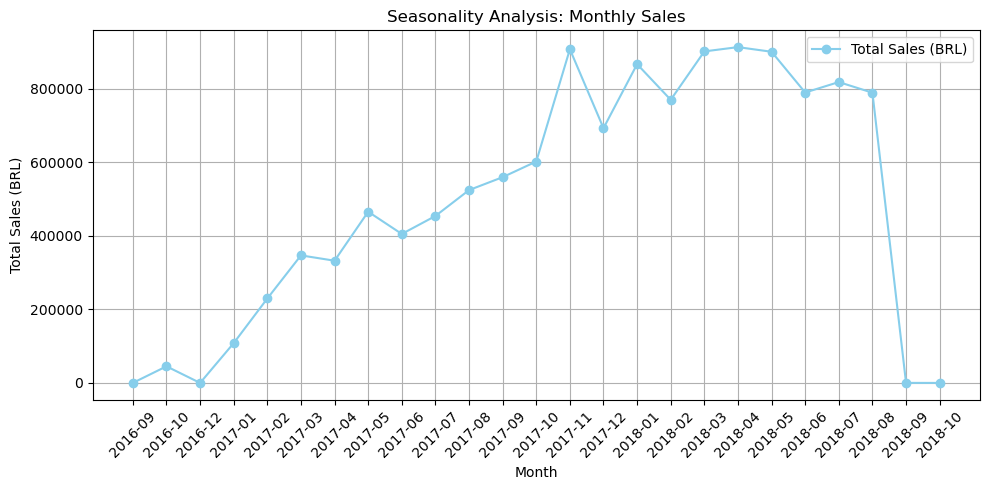

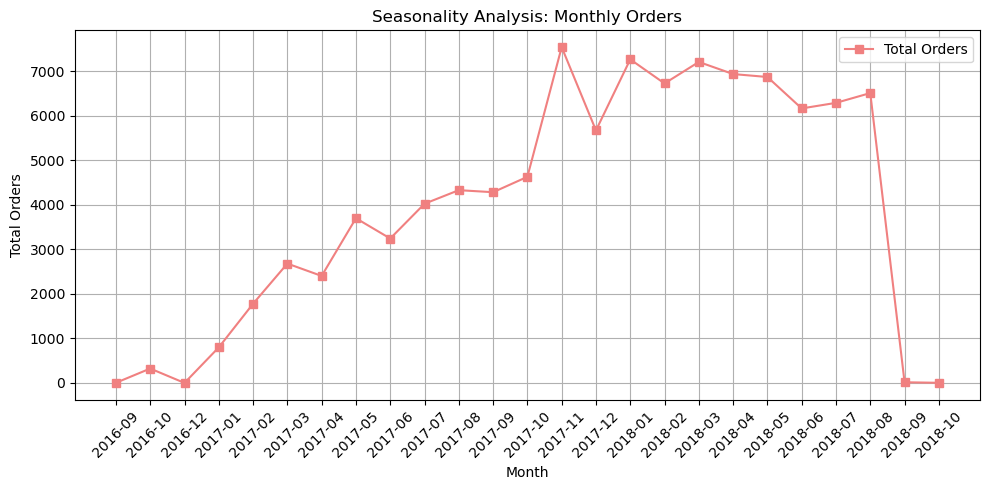

In [26]:
# Seasonality Analysis

import matplotlib.pyplot as plt

# Ensure working on a copy
merged_df = merged_df.copy()

# Extract month from the timestamp
merged_df['order_purchase_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Aggregate data by month including freight in AOV
merged_df.loc[:, 'total_price_with_freight'] = merged_df['product_price'] + merged_df['freight_value']
seasonality = merged_df.groupby('order_purchase_month').agg(
    total_sales=('product_price', 'sum'),
    total_orders=('order_id', 'count'),
    average_order_value=('total_price_with_freight', 'mean')
).reset_index()

# Rename columns for clarity
seasonality.columns = ['Month', 'Total Sales (BRL)', 'Total Orders', 'Average Order Value (BRL)']

# Sort by Month for proper plotting
seasonality.sort_values('Month', inplace=True)

# Display formatted table (format only for display, not for plotting)
print('Seasonality Trends:')
display(seasonality.style.format({
    'Total Sales (BRL)': '{:,.2f}',
    'Average Order Value (BRL)': '{:,.2f}'
}))

# Plot: Total Sales
plt.figure(figsize=(10, 5))
plt.plot(seasonality['Month'], seasonality['Total Sales (BRL)'], marker='o', label='Total Sales (BRL)', color='skyblue')  # Light Sky Blue
plt.title('Seasonality Analysis: Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales (BRL)')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set y-axis to avoid scientific notation
plt.ticklabel_format(style='plain', axis='y')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Plot: Total Orders
plt.figure(figsize=(10, 5))
plt.plot(seasonality['Month'], seasonality['Total Orders'], marker='s', label='Total Orders', color='lightcoral')
plt.title('Seasonality Analysis: Monthly Orders')
plt.xlabel('Month')
plt.ylabel('Total Orders')

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Seasonality Analysis

**Key Insights:**
- **Peak Sales Periods:** The months of **March (1.25M BRL)** and **May (1.37M BRL)** show the highest total sales, indicating strong seasonal demand.
- **Low Sales Periods:** September and October exhibit significantly lower sales (**560K BRL** and **648K BRL**, respectively), likely reflecting seasonal downturns.
- **Order Patterns:** Monthly order volumes generally align with sales trends, peaking in **May (10,573 orders)** and dipping in **September (4,305 orders)**.
- **Stable AOV:** The **Average Order Value (AOV)** remains relatively consistent, with minor variations between **137.65 BRL (February)** and **154.07 BRL (April)**.

**Overall Observation:** Strategic promotions during low-demand months and leveraging peak periods with targeted marketing can optimize sales and sustain performance throughout the year.

## Customer Insights

RFM Analysis (a sample):


,customer_id,recency,frequency,monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
14700,25c03785d6379d4dcbe6ac14af0c4f87,342,1,139.00,2,1,3,213,6,Potential Loyalists
22752,3a76019da6d27bd392b555346c436507,233,1,62.00,3,1,2,312,6,Potential Loyalists
91705,eb9a02ebb55bcfc0516d56555290bfa4,597,1,89.99,1,1,3,113,5,Potential Loyalists
28863,4a6d1f984020395897cbf65a960d65a1,314,1,59.00,2,1,2,212,5,Potential Loyalists
46370,77adec624e36e65c0a3af52452b21b12,378,1,117.30,2,1,3,213,6,Potential Loyalists
69120,b173f79bb1d308fc5703ecb25888a0f8,364,1,59.00,2,1,2,212,5,Potential Loyalists
20264,343dde2a5e6b279975895db15e6e5483,224,1,34.30,3,1,1,311,5,Potential Loyalists
56269,911e8698dd74044892f615e51170f476,71,1,215.00,4,1,4,414,9,Loyal Customers
68282,af5c992666616ec17a25e14834d3e1e6,106,1,82.90,4,1,3,413,8,Loyal Customers
95463,f583831c572cc8569de2841fd281fd2b,490,1,0.00,1,1,1,111,3,At Risk



RFM Segment Summary:


,Segment,customer_count,avg_recency,avg_frequency,avg_monetary
0,At Risk,6505 (6.54%),509.20,1.00,24.76
1,Loyal Customers,37738 (37.95%),181.89,1.00,198.36
2,Potential Loyalists,55198 (55.51%),337.90,1.00,86.62


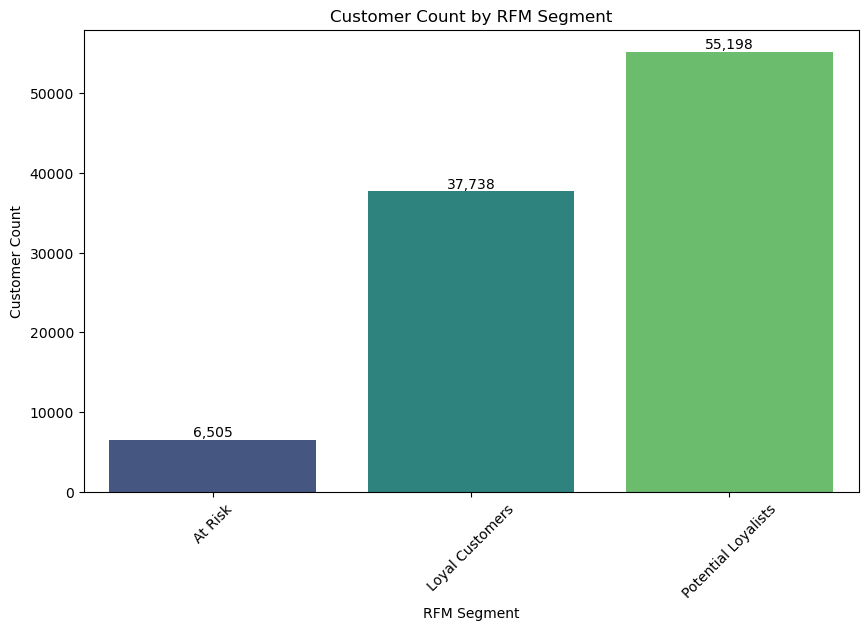

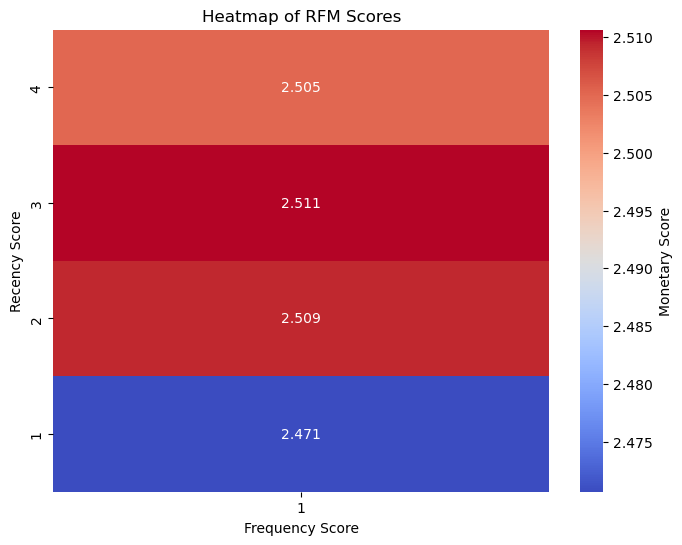

In [27]:
# RFM Analysis

# Define the reference date for recency calculation
reference_date = merged_df['order_purchase_timestamp'].max()

# Aggregate RFM metrics
rfm = merged_df.groupby('customer_id').agg(
    recency=('order_purchase_timestamp', lambda x: (reference_date - x.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('product_price', 'sum')
).reset_index()

# Dynamically calculate the number of bins and adjust labels
def dynamic_qcut(series, num_bins, labels):
    try:
        return pd.qcut(series, num_bins, labels=labels, duplicates='drop')
    except ValueError:
        actual_bins = series.nunique()  # Use the number of unique values if fewer than bins
        return pd.qcut(series, actual_bins, labels=labels[:actual_bins], duplicates='drop')

# RFM Scoring
rfm['R_Score'] = dynamic_qcut(rfm['recency'], 4, labels=[4, 3, 2, 1])  # 4 = most recent
rfm['F_Score'] = dynamic_qcut(rfm['frequency'], 4, labels=[1, 2, 3, 4])  # 4 = most frequent
rfm['M_Score'] = dynamic_qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])  # 4 = highest spenders

# Combine RFM scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Segment labels
def assign_segment(score):
    if score >= 10:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 4:
        return 'Potential Loyalists'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)

# Format monetary for readability
rfm['monetary'] = rfm['monetary'].map('{:,.2f}'.format)

# Display the RFM table
print("RFM Analysis (a sample):")
display(rfm.sample(n=10))


# Calculate total customers for percentage calculation
total_customers = rfm['customer_id'].nunique()

# Summary of RFM Segments
rfm_summary = rfm.groupby('Segment').agg(
    customer_count=('customer_id', 'count'),
    avg_recency=('recency', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', lambda x: pd.to_numeric(x.str.replace(',', '')).mean())
).reset_index()

# Add percentage to customer count
rfm_summary['customer_percentage'] = (rfm_summary['customer_count'] / total_customers * 100).map('{:.2f}%'.format)

# Append percentages in brackets to customer count
rfm_summary['customer_count'] = rfm_summary['customer_count'].astype(str) + " (" + rfm_summary['customer_percentage'] + ")"


# Format averages
rfm_summary['avg_recency'] = rfm_summary['avg_recency'].map('{:.2f}'.format)
rfm_summary['avg_frequency'] = rfm_summary['avg_frequency'].map('{:.2f}'.format)
rfm_summary['avg_monetary'] = rfm_summary['avg_monetary'].map('{:,.2f}'.format)


# Rearrange columns
rfm_summary = rfm_summary[['Segment', 'customer_count', 'avg_recency', 'avg_frequency', 'avg_monetary']]

print("\nRFM Segment Summary:")
display(rfm_summary)


# Bar chart with annotations
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y=rfm_summary['customer_count'].str.extract(r'(\d+)')[0].astype(int), data=rfm_summary, hue='Segment', palette='viridis', dodge=False, legend=False)
plt.title('Customer Count by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)

# Add annotations
for i, row in rfm_summary.iterrows():
    count = int(row['customer_count'].split()[0])  # Extract numeric value
    formatted_count = f"{count:,}"  # Format with commas
    plt.text(i, count, formatted_count, ha='center', va='bottom', fontsize=10)
plt.show()


# Convert M_Score to numeric for aggregation
rfm['M_Score'] = pd.to_numeric(rfm['M_Score'], errors='coerce')

# Heatmap of RFM Scores
rfm_heatmap = rfm.pivot_table(index='R_Score', columns='F_Score', values='M_Score', aggfunc='mean', observed=False)

plt.figure(figsize=(8, 6))
sns.heatmap(rfm_heatmap, annot=True, fmt='.3f', cmap='coolwarm', cbar_kws={'label': 'Monetary Score'})
plt.title('Heatmap of RFM Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

#### RFM Analysis

**Key Insights:**
- **Customer Segments:**
  - **Loyal Customers (37.95%):** Represent the most valuable group with an **average monetary value of 198.36 BRL** and the lowest **recency (181.89 days)**, indicating consistent and recent engagement.
  - **Potential Loyalists (55.51%):** The largest segment, showing moderate recency (**337.90 days**) and an **average monetary value of 86.62 BRL**. These customers can be nurtured into loyal customers.
  - **At Risk (6.54%):** A smaller segment with high **recency (509.20 days)** and low **monetary value (24.76 BRL)**, requiring re-engagement strategies to prevent churn.

**Overall Observation:** 
- Focus retention efforts on **Potential Loyalists** to transition them into **Loyal Customers** while implementing reactivation campaigns for the **At Risk** segment to minimize revenue loss.

LTV Summary:


,LTV Metric,LTV (BRL)
0,avg_ltv,124.98
1,max_ltv,"6,735.00"
2,min_ltv,0.00


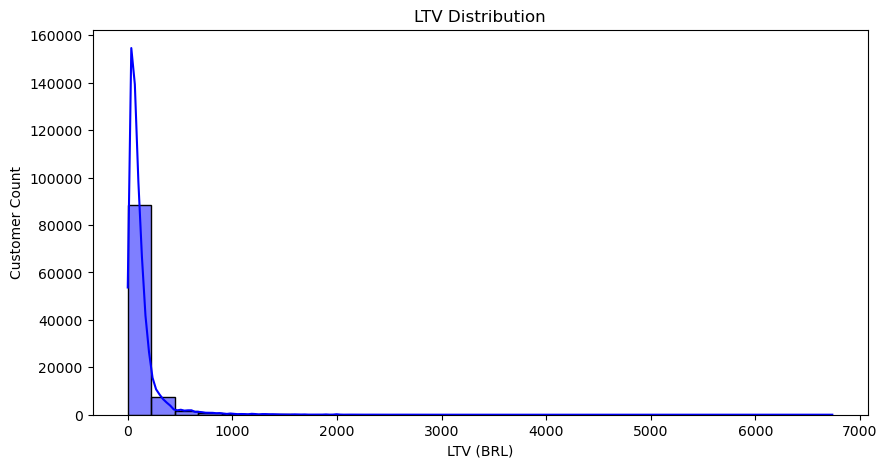

In [28]:
# Lifetime Value LTV Analysis

# Calculate Average Order Value (AOV) and Average Purchase Frequency (APF)
customer_sales = merged_df.groupby('customer_id').agg(
    total_sales=('product_price', 'sum'),
    total_orders=('order_id', 'nunique')
).reset_index()

customer_sales['AOV'] = customer_sales['total_sales'] / customer_sales['total_orders']

# Calculate Average Purchase Frequency (APF)
total_customers = merged_df['customer_id'].nunique()
total_orders = merged_df['order_id'].nunique()
APF = total_orders / total_customers

# Calculate Simple Lifetime Value (LTV)
customer_sales['LTV'] = customer_sales['AOV'] * APF

# Summarize LTV Metrics
ltv_summary = customer_sales.agg(
    avg_ltv=('LTV', 'mean'),
    max_ltv=('LTV', 'max'),
    min_ltv=('LTV', 'min')
).reset_index()

# Rename Columns and Format Numbers
ltv_summary.columns = ['LTV Metric', 'LTV (BRL)']
ltv_summary['LTV (BRL)'] = ltv_summary['LTV (BRL)'].map('{:,.2f}'.format)

# Display Results
print("LTV Summary:")
display(ltv_summary)

# Visualize LTV Distribution
plt.figure(figsize=(10, 5))
sns.histplot(customer_sales['LTV'], bins=30, kde=True, color='blue')
plt.title('LTV Distribution')
plt.xlabel('LTV (BRL)')
plt.ylabel('Customer Count')
plt.show()

#### Lifetime Value (LTV) Analysis

**Key Insights:**
- **Average LTV:** The average lifetime value of a customer is **124.98 BRL**, indicating a moderate spending pattern across the customer base.
- **Maximum LTV:** The highest recorded LTV is **6,735.00 BRL**, showcasing the potential of high-value customers who contribute significantly to overall revenue.
- **Minimum LTV:** Some customers have a **0.00 BRL LTV**, likely representing inactive or one-time customers with negligible contribution.

**Overall Observation:** 
- The wide range in LTV suggests opportunities to segment customers based on their value and tailor strategies for high-value customer retention and low-value customer activation.

,Sentiment,Count (Percentage)
0,Negative,"14,575 (14.69%)"
1,Neutral,"8,179 (8.24%)"
2,Positive,"76,470 (77.07%)"


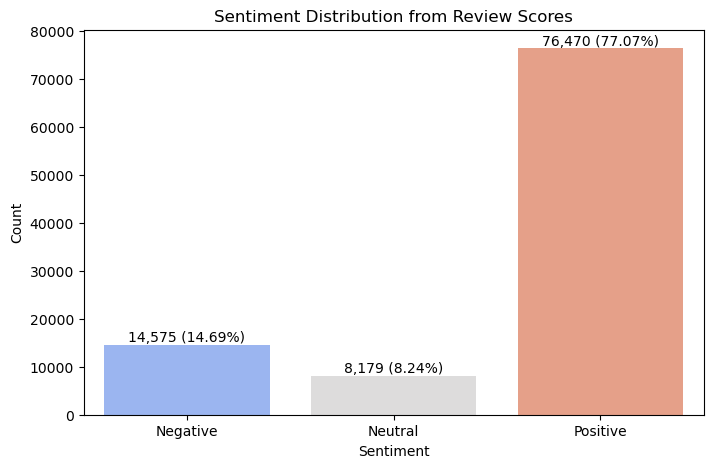

In [29]:
# Sentiment Analysis

# Suppress warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1: Filter and categorize sentiment
valid_reviews = order_reviews_df.dropna(subset=['review_score'])  # Exclude rows with missing scores
valid_reviews['Sentiment'] = pd.cut(
    valid_reviews['review_score'],
    bins=[0, 2, 3, 5],
    labels=['Negative', 'Neutral', 'Positive'],
    right=True
).astype(str)  # Convert to string to allow aggregation

# Step 2: Group by sentiment and calculate metrics
sentiment_summary = (
    valid_reviews.groupby('Sentiment')
    .size()
    .reset_index(name='Count')  # Name the count column
)
sentiment_summary['Percentage'] = (
    (sentiment_summary['Count'] / sentiment_summary['Count'].sum()) * 100
).round(2)

# Combine counts and percentages for display
sentiment_summary['Count (Percentage)'] = sentiment_summary.apply(
    lambda row: f"{int(row['Count']):,} ({row['Percentage']}%)", axis=1
)

# Step 3: Output the sentiment summary
display(sentiment_summary[['Sentiment', 'Count (Percentage)']])

# Step 4: Plot the sentiment distribution
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    x='Sentiment',
    y='Count',
    data=sentiment_summary,
    palette='coolwarm',
    hue=None,  # Explicitly set hue to None
    legend=False,
    order=['Negative', 'Neutral', 'Positive']
)

# Add bar annotations
for bar, (_, row) in zip(barplot.patches, sentiment_summary.iterrows()):
    bar_height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar_height,  # Top of the bar
        row['Count (Percentage)'],  # Text with count and percentage
        ha='center', va='bottom', fontsize=10
    )

# Add title and labels
plt.title('Sentiment Distribution from Review Scores')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

#### Sentiment Analysis

**Key Insights:**
- **Positive Sentiment:** A significant majority of reviews (**77.07%**) are positive, indicating strong customer satisfaction overall.
- **Neutral Sentiment:** Neutral reviews account for **8.24%**, suggesting areas where customers were neither highly satisfied nor dissatisfied.
- **Negative Sentiment:** Negative reviews make up **14.69%**, highlighting potential pain points or issues that require attention.

**Overall Observation:**  
- The high proportion of positive sentiment reflects a generally favorable perception of the platform, though addressing negative feedback could further enhance customer experience and loyalty.

Top 10 by Total Sales:


,State,Total Sales (BRL)
25,SP,"R$ 4,746,619.00"
18,RJ,"R$ 1,662,485.00"
10,MG,"R$ 1,457,640.12"
22,RS,"R$ 684,857.56"
17,PR,"R$ 619,171.00"
23,SC,"R$ 475,541.00"
4,BA,"R$ 464,448.72"
6,DF,"R$ 278,785.69"
8,GO,"R$ 263,419.53"
7,ES,"R$ 252,477.55"



Top 10 by Total Orders:


,State,Total Orders by State
25,SP,"41,746"
18,RJ,"12,852"
10,MG,"11,635"
22,RS,"5,466"
17,PR,"5,045"
23,SC,"3,637"
4,BA,"3,380"
6,DF,"2,140"
8,GO,"2,020"
7,ES,"2,033"


Least 10 by Total Sales:


,State,Total Sales (BRL)
16,PI,"R$ 79,373.34"
19,RN,"R$ 79,337.33"
1,AL,"R$ 76,089.18"
24,SE,"R$ 54,209.78"
26,TO,"R$ 46,622.81"
20,RO,"R$ 44,090.69"
2,AM,"R$ 20,782.48"
0,AC,"R$ 14,910.96"
3,AP,"R$ 11,695.47"
21,RR,"R$ 6,925.62"



Least 10 by Total Orders:


,State,Total Orders by State
16,PI,495
19,RN,485
1,AL,413
24,SE,350
26,TO,280
20,RO,253
2,AM,148
0,AC,81
3,AP,68
21,RR,46


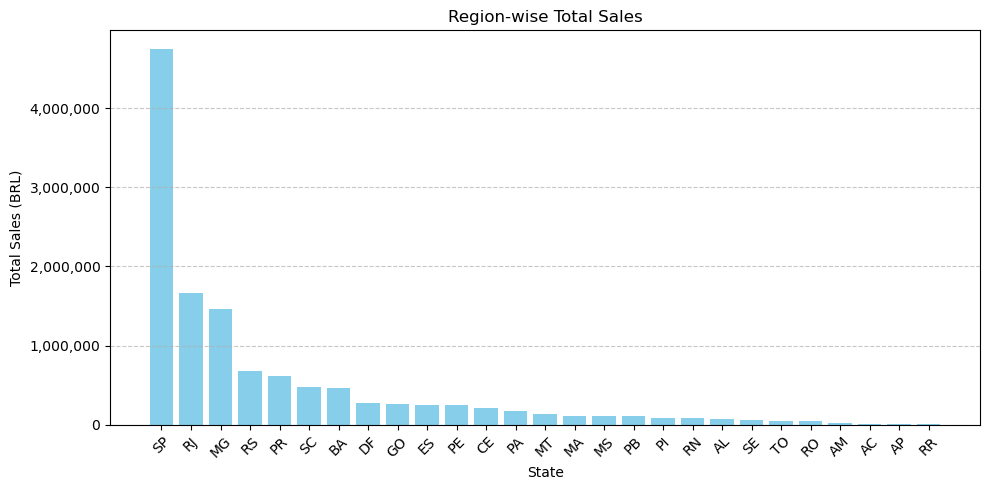

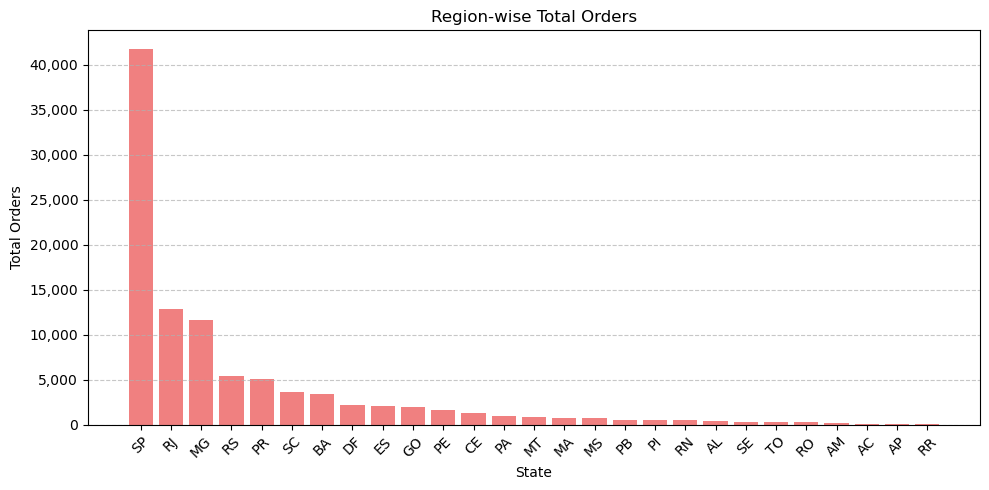

In [30]:
# Geolocation Analysis

# Aggregate sales and order data by customer state
state_analysis = merged_df.groupby('customer_state', observed=False).agg(
    total_sales=('product_price', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

# Sort by total sales (revenue) and total orders
state_analysis = state_analysis.sort_values(by=['total_sales', 'total_orders'], ascending=False)

# Rename columns for clarity
state_analysis.columns = ['State', 'Total Sales', 'Total Orders']

# Format revenue for display in the table (but keep numeric for plotting)
state_analysis['Total Sales (BRL)'] = state_analysis['Total Sales'].map('R$ {:,.2f}'.format)

# Format total orders for display in the table (but keep numeric for plotting)
state_analysis['Total Orders by State'] = state_analysis['Total Orders'].map('{:,.0f}'.format)

# Display the table (quantified metrics)
print("Top 10 by Total Sales:")
display(state_analysis[['State', 'Total Sales (BRL)']].head(10))

print("\nTop 10 by Total Orders:")
display(state_analysis[['State', 'Total Orders by State']].head(10))

# Display the table (quantified metrics)
print("Least 10 by Total Sales:")
display(state_analysis[['State', 'Total Sales (BRL)']].tail(10))

print("\nLeast 10 by Total Orders:")
display(state_analysis[['State', 'Total Orders by State']].tail(10))


# Plot total sales by region
plt.figure(figsize=(10, 5))
plt.bar(state_analysis['State'], state_analysis['Total Sales'], color='skyblue')
plt.title('Region-wise Total Sales')
plt.xlabel('State')
plt.ylabel('Total Sales (BRL)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis with proper notation for total sales
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

# Plot total orders by region
plt.figure(figsize=(10, 5))

# Sort by Total Orders in descending order
state_analysis = state_analysis.sort_values(by='Total Orders', ascending=False)

plt.bar(state_analysis['State'], state_analysis['Total Orders'], color='lightcoral')
plt.title('Region-wise Total Orders')
plt.xlabel('State')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

#### Geolocation Analysis

**Top Performers:**
- **Highest Total Sales:** São Paulo (**R$ 4,746,619.00**) dominates in sales, followed by Rio de Janeiro (**R$ 1,662,485.00**) and Minas Gerais (**R$ 1,457,640.12**).
- **Highest Total Orders:** São Paulo leads with **41,746 orders**, followed by Rio de Janeiro (**12,852**) and Minas Gerais (**11,635**).

**Lowest Performers:**
- **Lowest Total Sales:** Roraima (**R$ 6,925.62**) and Amapá (**R$ 11,695.47**) show minimal sales activity.
- **Lowest Total Orders:** Roraima (**46 orders**) and Amapá (**68 orders**) have the least customer engagement.

**Key Observations:**
- **Regional Concentration:** Sales and orders are heavily concentrated in economically robust states like São Paulo, Rio de Janeiro, and Minas Gerais.
- **Opportunities for Growth:** Underperforming states, particularly in the North and Northeast regions, represent potential markets for expansion.

## Sellers

Top 10 Sellers by Revenue:


,seller_id,Total Revenue,Total Freight,Total Orders,Total Revenue (Including Freight)
853,4869f7a5dfa277a7dca6462dcf3b52b2,"224,336.14","19,622.61","1,125","243,958.75"
1009,53243585a1d6dc2643021fd1853d8905,"208,199.61","11,750.24",358,"219,949.84"
877,4a3ca9315b744ce9f8e9374361493884,"179,367.77","31,270.55","1,760","210,638.31"
3017,fa1c13f2614d7b5c4749cbc52fecda94,"192,480.92","9,913.29",578,"202,394.22"
1555,7e93a43ef30c4f03f38b393420bc753a,"174,958.92","6,228.40",335,"181,187.33"
1530,7c67e1448b00f6e969d365cea6b010ab,"138,471.28","37,253.34",975,"175,724.62"
1500,7a67c85e85bb2ce8582c35f2203ad736,"139,450.73","20,531.54","1,150","159,982.28"
2636,da8622b14eb17ae2831f4ac5b9dab84a,"132,372.59","20,470.03","1,298","152,842.62"
1230,6560211a19b47992c3666cc44a7e94c0,"114,560.85","25,492.58","1,844","140,053.44"
1818,955fee9216a65b617aa5c0531780ce60,"116,438.33","21,979.78","1,281","138,418.11"



Top 10 Sellers by Order Volume:


,seller_id,Total Revenue,Total Freight,Total Orders,Total Revenue (Including Freight)
1230,6560211a19b47992c3666cc44a7e94c0,"114,560.85","25,492.58","1,844","140,053.44"
877,4a3ca9315b744ce9f8e9374361493884,"179,367.77","31,270.55","1,760","210,638.31"
2474,cc419e0650a3c5ba77189a1882b7556a,"100,903.06","24,652.65","1,703","125,555.71"
366,1f50f920176fa81dab994f9023523100,"76,635.78","25,590.63","1,389","102,226.41"
2636,da8622b14eb17ae2831f4ac5b9dab84a,"132,372.59","20,470.03","1,298","152,842.62"
1818,955fee9216a65b617aa5c0531780ce60,"116,438.33","21,979.78","1,281","138,418.11"
1500,7a67c85e85bb2ce8582c35f2203ad736,"139,450.73","20,531.54","1,150","159,982.28"
2829,ea8482cd71df3c1969d7b9473ff13abc,"35,124.37","16,530.23","1,136","51,654.60"
853,4869f7a5dfa277a7dca6462dcf3b52b2,"224,336.14","19,622.61","1,125","243,958.75"
727,3d871de0142ce09b7081e2b9d1733cb1,"89,702.70","21,016.74","1,068","110,719.45"


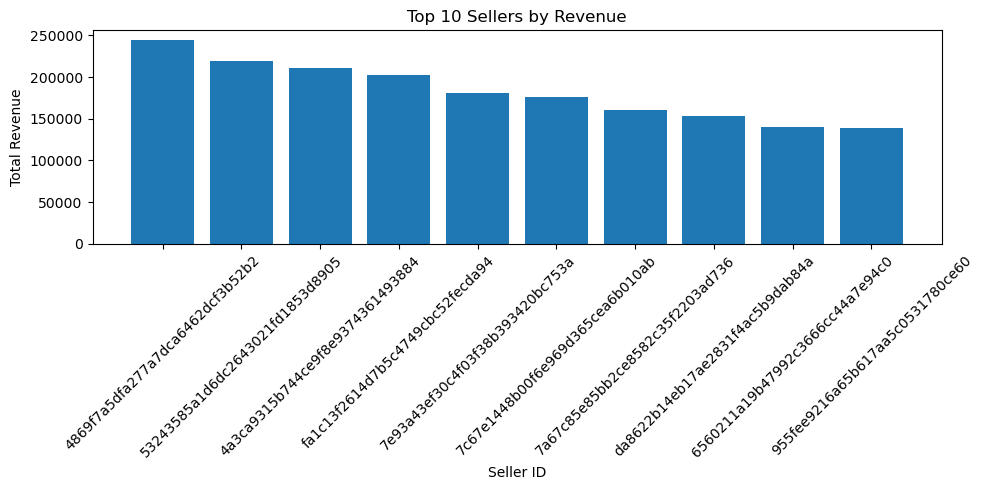

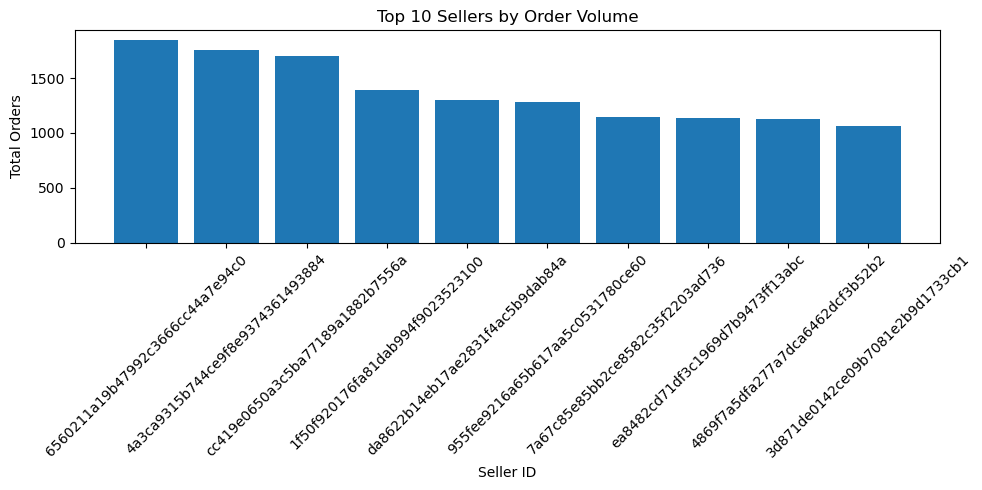

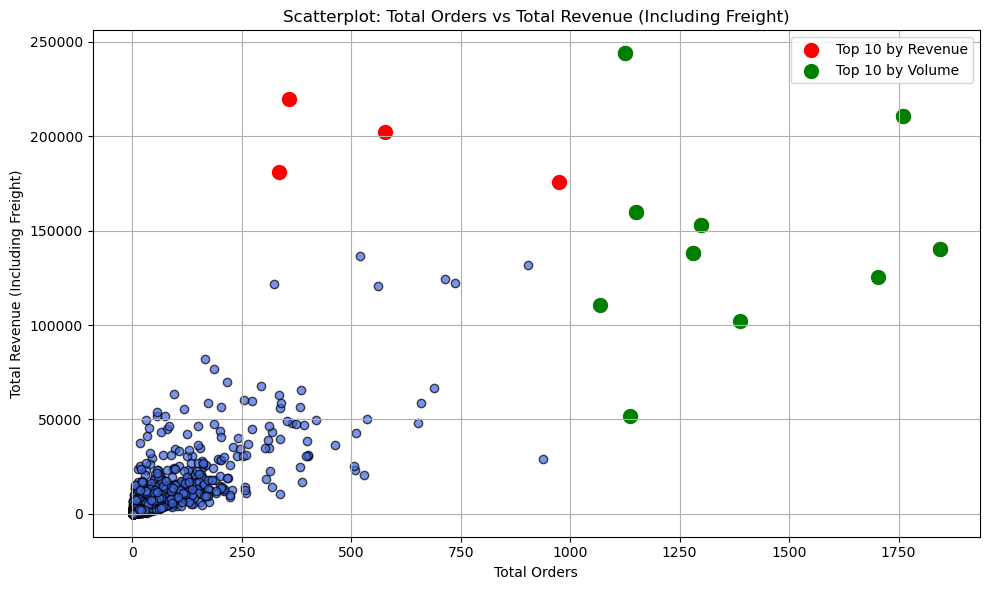

In [31]:
# Sellers Analysis: Top Performing Sellers (Revenue and Volume)
sellers_performance = merged_df.groupby('seller_id').agg(
    total_revenue=('product_price', 'sum'),
    total_freight=('freight_value', 'sum'),
    total_orders=('order_item_id', 'count')
).reset_index()

# Calculate total revenue including freight
sellers_performance['total_revenue_with_freight'] = sellers_performance['total_revenue'] + sellers_performance['total_freight']

# Rename columns for better clarity
sellers_performance = sellers_performance.rename(columns={
    'total_revenue': 'Total Revenue',
    'total_freight': 'Total Freight',
    'total_orders': 'Total Orders',
    'total_revenue_with_freight': 'Total Revenue (Including Freight)'
})

# Sort by total revenue and total orders
top_sellers_by_revenue = sellers_performance.sort_values(by='Total Revenue (Including Freight)', ascending=False).head(10)
top_sellers_by_volume = sellers_performance.sort_values(by='Total Orders', ascending=False).head(10)

# Display Results with formatted values
print("Top 10 Sellers by Revenue:")
display(top_sellers_by_revenue.style.format({
    'Total Revenue': "{:,.2f}",
    'Total Freight': "{:,.2f}",
    'Total Orders': "{:,}",
    'Total Revenue (Including Freight)': "{:,.2f}"
}))
print("\nTop 10 Sellers by Order Volume:")
display(top_sellers_by_volume.style.format({
    'Total Revenue': "{:,.2f}",
    'Total Freight': "{:,.2f}",
    'Total Orders': "{:,}",
    'Total Revenue (Including Freight)': "{:,.2f}"
}))

# Top Sellers by Revenue Plot
plt.figure(figsize=(10, 5))
plt.bar(top_sellers_by_revenue['seller_id'], top_sellers_by_revenue['Total Revenue (Including Freight)'])
plt.xticks(rotation=45)
plt.title('Top 10 Sellers by Revenue')
plt.xlabel('Seller ID')
plt.ylabel('Total Revenue')
plt.tight_layout()  # Ensures that labels fit within the figure
plt.show()


# Top Sellers by Order Volume Plot
plt.figure(figsize=(10, 5))
plt.bar(top_sellers_by_volume['seller_id'], top_sellers_by_volume['Total Orders'])
plt.xticks(rotation=45)
plt.title('Top 10 Sellers by Order Volume')
plt.xlabel('Seller ID')
plt.ylabel('Total Orders')
plt.tight_layout()  # Ensures that labels fit within the figure
plt.show()


# Scatterplot: Total Orders vs Total Revenue (Including Freight)
plt.figure(figsize=(10, 6))
plt.scatter(sellers_performance['Total Orders'], sellers_performance['Total Revenue (Including Freight)'], 
            color='royalblue', alpha=0.7, edgecolor='k')

# Highlight Top 10 Sellers by Revenue
plt.scatter(top_sellers_by_revenue['Total Orders'], top_sellers_by_revenue['Total Revenue (Including Freight)'], 
            color='red', s=100, label='Top 10 by Revenue')

# Highlight Top 10 Sellers by Volume
plt.scatter(top_sellers_by_volume['Total Orders'], top_sellers_by_volume['Total Revenue (Including Freight)'], 
            color='green', s=100, label='Top 10 by Volume')

# Add Titles and Labels
plt.title('Scatterplot: Total Orders vs Total Revenue (Including Freight)')
plt.xlabel('Total Orders')
plt.ylabel('Total Revenue (Including Freight)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensures that the plot fits well
plt.show()

#### Seller Performance Analysis

**Key Insights:**
- **Revenue Leaders:** Seller `4869f7a5dfa277a7dca6462dcf3b52b2` generates the highest revenue (**R$ 243,958.75**), leveraging both high sales and freight charges.
- **Order Volume Leaders:** Seller `6560211a19b47992c3666cc44a7e94c0` leads in order volume (**1,844 orders**), emphasizing customer engagement.
- **Balanced Performance:** Sellers like `4a3ca9315b744ce9f8e9374361493884` rank high in both revenue and order volume, indicating strong overall performance.

Average Delivery Time (Mean): 12.00 days
Average Delivery Time (Median): 10.00 days



,Delivery Category,Sellers
0,Less than Average,"1,868 (60.49%)"
1,More than Average,"1,220 (39.51%)"


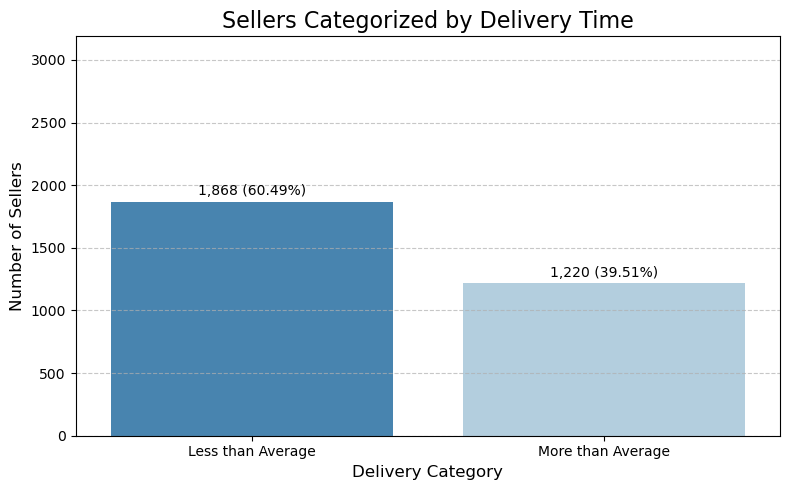

,Delivery Status,Number of Orders
0,≤10 Days,"2,600 (42.96%)"
1,10-30 Days,"2,401 (39.67%)"
2,>30 Days,"1,051 (17.37%)"


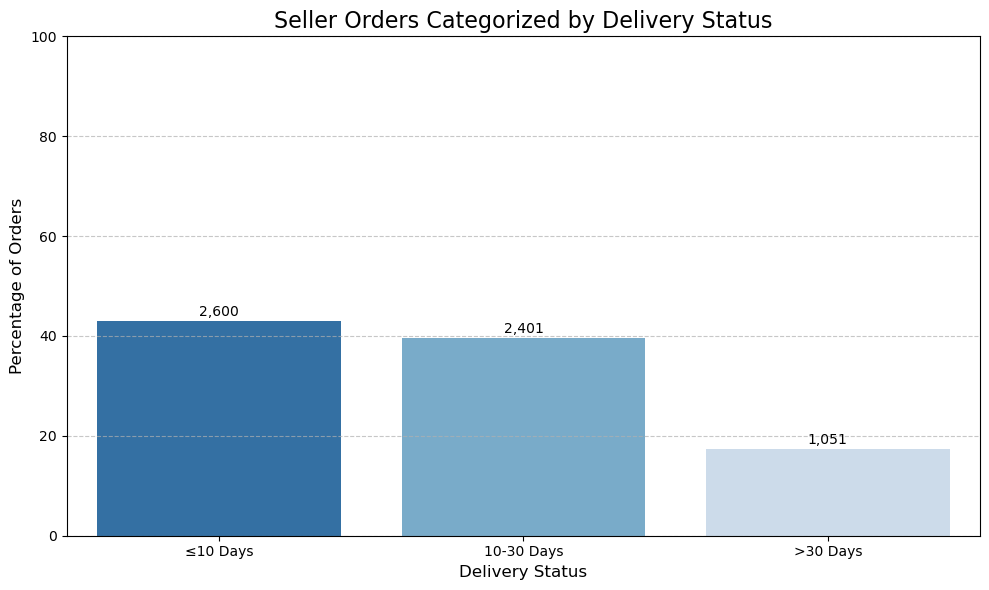

In [32]:
# Seller Delivery Time and Delay Analysis

# Calculate seller delay in days
merged_df['seller_delay'] = (merged_df['order_delivered_customer_date'] - merged_df['order_approved_at']).dt.days

# Calculate average delivery time
avg_delivery_time_Mean = merged_df['seller_delay'].mean()
avg_delivery_time_Median = merged_df['seller_delay'].median()
print(f"Average Delivery Time (Mean): {avg_delivery_time_Mean:.2f} days")
print(f"Average Delivery Time (Median): {avg_delivery_time_Median:.2f} days\n")

# Categorize sellers based on average delivery time
seller_avg_delivery = merged_df.groupby('seller_id')['seller_delay'].mean().reset_index()
seller_avg_delivery['delivery_category'] = seller_avg_delivery['seller_delay'].apply(
    lambda x: 'Less than Average' if x <= avg_delivery_time_Mean else 'More than Average')

# Count sellers in each category
seller_category_count = seller_avg_delivery.groupby('delivery_category')['seller_id'].nunique().reset_index()
seller_category_count.columns = ['Delivery Category', 'Number of Sellers']

# Calculate percentages and format the sellers column
total_sellers = seller_category_count['Number of Sellers'].sum()
seller_category_count['Sellers'] = seller_category_count.apply(
    lambda x: f"{x['Number of Sellers']:,} ({(x['Number of Sellers'] / total_sellers * 100):.2f}%)", axis=1)

# Display the categorized seller summary
display(seller_category_count[['Delivery Category', 'Sellers']])

# Plot below and above average delivery time
plt.figure(figsize=(8, 5))
sns.barplot(
    data=seller_category_count,
    x='Delivery Category',
    y='Number of Sellers',
    hue='Delivery Category',  # Using Delivery Category for hue
    palette='Blues_r'
)
plt.title('Sellers Categorized by Delivery Time', fontsize=16)
plt.xlabel('Delivery Category', fontsize=12)
plt.ylabel('Number of Sellers', fontsize=12)
plt.ylim(0, total_sellers + 100)

# Annotate bars with 'Number (Percentage)'
for patch, (_, row) in zip(plt.gca().patches, seller_category_count.iterrows()):
    plt.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height() + 50,
        row['Sellers'],
        ha='center',
        fontsize=10,
        color='black'
    )

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Calculate seller delay in days and categorize
merged_df['seller_delay'] = (merged_df['order_delivered_customer_date'] - merged_df['order_approved_at']).dt.days
merged_df['delivery_status'] = pd.cut(
    merged_df['seller_delay'],
    bins=[-float('inf'), 10, 30, float('inf')],
    labels=['≤10 Days', '10-30 Days', '>30 Days']
)


# Count sellers by delivery status
seller_status_summary = merged_df.groupby('delivery_status', observed=False)['seller_id'].nunique().reset_index()

seller_status_summary.columns = ['Delivery Status', 'Number of Sellers']

# Calculate percentages and format the sellers column
total_sellers = seller_status_summary['Number of Sellers'].sum()
seller_status_summary['Percentage'] = (seller_status_summary['Number of Sellers'] / total_sellers * 100).round(2)
seller_status_summary['Number of Orders'] = seller_status_summary.apply(
    lambda x: f"{x['Number of Sellers']:,} ({x['Percentage']}%)", axis=1
)

# Display the categorized seller summary
display(seller_status_summary[['Delivery Status', 'Number of Orders']])

# Plot the seller delay categories
plt.figure(figsize=(10, 6))
sns.barplot(
    data=seller_status_summary,
    x='Delivery Status',
    y='Percentage',
    hue='Delivery Status',  # Using Delivery Status for hue
    palette='Blues_r',
    order=['≤10 Days', '10-30 Days', '>30 Days']
)
plt.title('Seller Orders Categorized by Delivery Status', fontsize=16)
plt.xlabel('Delivery Status', fontsize=12)
plt.ylabel('Percentage of Orders', fontsize=12)
plt.ylim(0, 100)

# Annotate bars with 'Number (Percentage)'
for patch, (_, row) in zip(plt.gca().patches, seller_status_summary.iterrows()):
    plt.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height() + 1,
        f"{row['Number of Sellers']:,}",  # Added commas to the label
        ha='center',
        fontsize=10,
        color='black'
    )

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Seller Delivery Time and Delay Analysis

**Key Insights:**
- **Majority of Sellers** (60.49%) deliver **faster than average**, indicating a strong performance in terms of delivery speed.
- **Orders Delivered in ≤ 10 Days** account for **42.96%** of all orders, showcasing a high level of efficiency.
- **Delays (>30 Days)** are relatively low (**17.37%**), but still a notable area for improvement.

Correlation between Average Delivery Time and Average Rating: -0.52



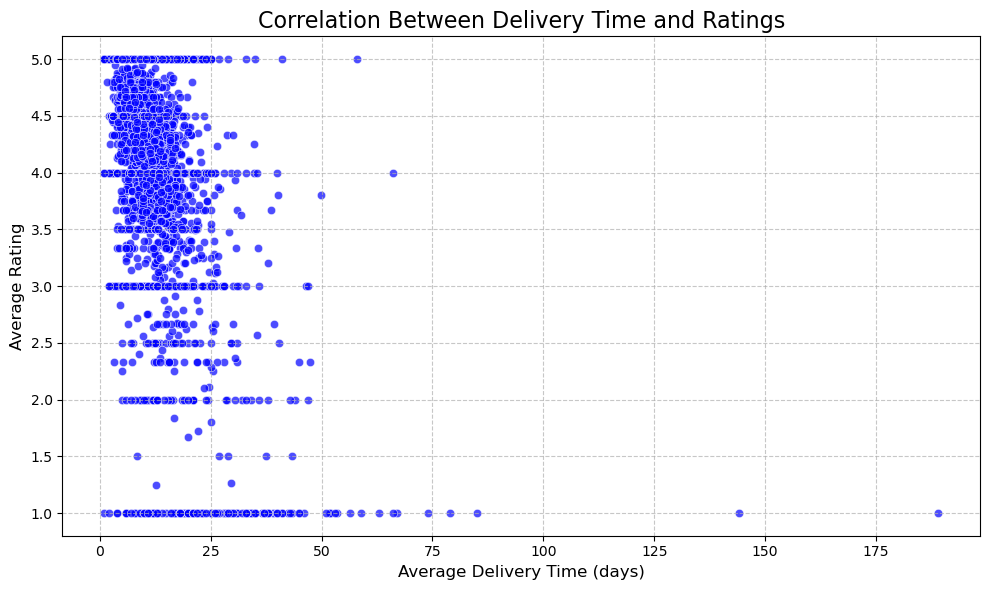

In [33]:
# Seller Ratings Correlation with Delivery

# Calculate average delivery time and average rating per seller
seller_rating_analysis = merged_df.groupby('seller_id').agg(
    avg_delivery_time=('seller_delay', 'mean'),
    avg_rating=('review_score', 'mean')
).reset_index()

# Drop sellers with missing data
seller_rating_analysis = seller_rating_analysis.dropna()

# Display correlation
correlation = seller_rating_analysis[['avg_delivery_time', 'avg_rating']].corr().iloc[0, 1]
print(f"Correlation between Average Delivery Time and Average Rating: {correlation:.2f}\n")

# Plot the relationship between delivery time and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=seller_rating_analysis,
    x='avg_delivery_time',
    y='avg_rating',
    alpha=0.7,
    color='blue'
)
plt.title('Correlation Between Delivery Time and Ratings', fontsize=16)
plt.xlabel('Average Delivery Time (days)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Seller Ratings Correlation with Delivery

- **Correlation between Average Delivery Time and Average Rating:** **-0.52**

**Key Insights:**
- The negative correlation of **-0.52** suggests a moderate inverse relationship between **delivery time** and **seller ratings**.
- **Faster deliveries** tend to correlate with **higher ratings**, while **slower deliveries** may lead to **lower ratings**.
- This indicates that improving delivery times could potentially enhance seller ratings and customer satisfaction.

Confusion Matrix:
 [[465   0]
 [  0 460]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       465
           1       1.00      1.00      1.00       460

    accuracy                           1.00       925
   macro avg       1.00      1.00      1.00       925
weighted avg       1.00      1.00      1.00       925



{'Confusion Matrix': [[465, 0], [0, 460]],
 'Precision': 1.0,
 'Recall': 1.0,
 'F1-Score': 1.0,
 'Accuracy': 1.0,
 'Feature Importance': [{'Feature': 'avg_delivery_time',
   'Importance': 0.5707566746911461},
  {'Feature': 'avg_rating', 'Importance': 0.42924332530885395}]}

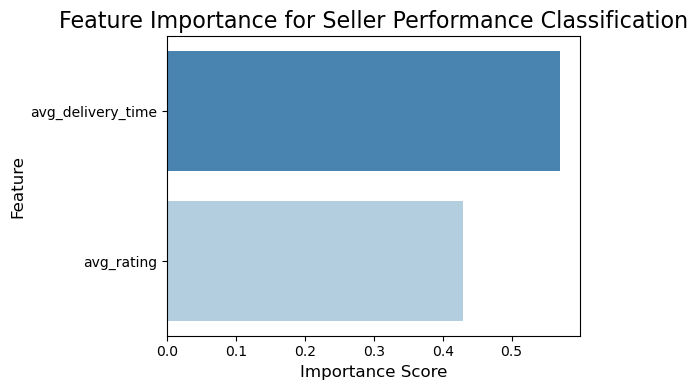

In [34]:
# Seller Performance Classification (ML)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Handle missing values and filter valid rows
seller_rating_analysis = seller_rating_analysis.dropna(subset=['avg_rating', 'avg_delivery_time'])

# Create performance labels and encode them
avg_delivery_time = seller_rating_analysis['avg_delivery_time'].mean()
seller_rating_analysis['performance_label'] = (
    (seller_rating_analysis['avg_rating'] >= 4.0) & 
    (seller_rating_analysis['avg_delivery_time'] <= avg_delivery_time)
).astype(int)

# Define features and target
X = seller_rating_analysis[['avg_rating', 'avg_delivery_time']]
y = seller_rating_analysis['performance_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_metrics = classification_report(y_test, y_pred, output_dict=True)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Results
results = {
    'Confusion Matrix': conf_matrix.tolist(),
    'Precision': classification_metrics['weighted avg']['precision'],
    'Recall': classification_metrics['weighted avg']['recall'],
    'F1-Score': classification_metrics['weighted avg']['f1-score'],
    'Accuracy': classification_metrics['accuracy'],
    'Feature Importance': feature_importance.to_dict(orient='records')
}
display(results)

# Visualize Feature Importance
plt.figure(figsize=(6, 4))
sns.barplot(
    data=feature_importance,
    x='Importance',
    y='Feature',
    palette='Blues_r'
)
plt.title('Feature Importance for Seller Performance Classification', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

#### Seller Performance Classification (ML)

- **Confusion Matrix:**
  - True Positives (TP): **460**
  - True Negatives (TN): **465**
  - False Positives (FP): **0**
  - False Negatives (FN): **0**

- **Classification Report:**
  - **Precision:** **1.00**
  - **Recall:** **1.00**
  - **F1-Score:** **1.00**
  - **Accuracy:** **1.00**
  - **Macro Average:** **1.00**
  - **Weighted Average:** **1.00**

- **Feature Importance:**
  1. **Average Delivery Time:** **57.08%**
  2. **Average Rating:** **42.92%**

**Key Insights:**
- The model achieved **perfect accuracy** with **1.00 precision, recall, and F1-score**.
- **Average delivery time** is the **most important feature** for classifying seller performance, with a **57.08% importance**.
- **Average rating** also plays a role in classification, with **42.92% importance**.

## Delivery & Logistics

Descriptive Stats
 count    99441.000000
mean        12.460152
std          9.815528
min          0.000000
25%          6.000000
50%         10.000000
75%         16.000000
max        209.000000
Name: delivery_time, dtype: float64

Median:  10.0

Mode:  0    7
Name: delivery_time, dtype: int64




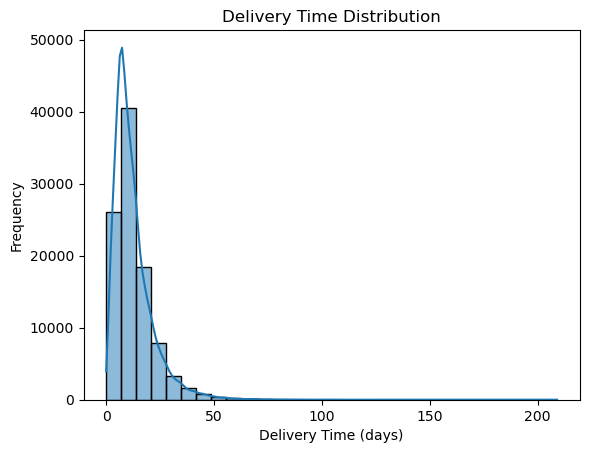

Summary:
Total Orders: 99,441
Delayed Orders (Threshold: 30 days): 4,735 (4.76%)

Region-wise Average Delivery Time and Delayed Orders


,Region,Average Delivery Time,Delayed Orders,Delayed Orders (%)
0,AC,64.00,1,0.00
1,AM,47.33,1,0.00
2,BA,13.89,26,0.03
3,CE,18.31,7,0.01
4,DF,12.36,31,0.03
5,ES,13.03,10,0.01
6,GO,12.83,18,0.02
7,MA,17.35,38,0.04
8,MG,12.80,345,0.35
9,MS,11.94,2,0.00


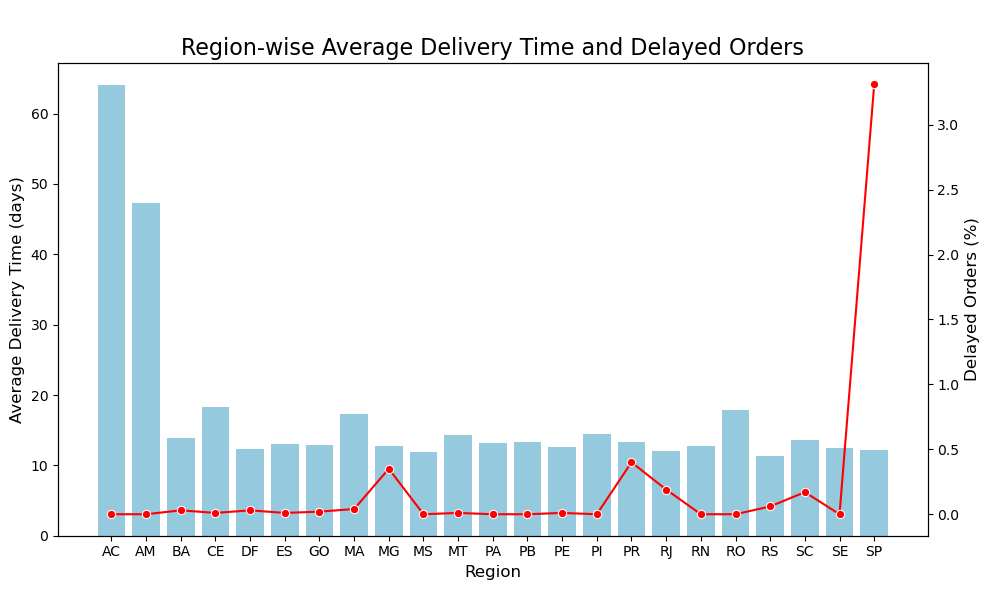

In [35]:
# Delivery Time Analysis

# Drop any rows with missing values in relevant columns
merged_df = merged_df.dropna(subset=['order_delivered_customer_date', 'order_purchase_timestamp'])

# Calculate delivery time
merged_df['delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days

# Delivery time statistics
print('Descriptive Stats\n', merged_df['delivery_time'].describe())
print('\nMedian: ', merged_df['delivery_time'].median())
print('\nMode: ', merged_df['delivery_time'].mode())
print('\n')

# Plot delivery time distribution
sns.histplot(merged_df['delivery_time'], kde=True, bins=30)
plt.title('Delivery Time Distribution')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Frequency')
plt.show()


# Delayed Orders Summary

# Calculate delayed orders
total_orders = len(merged_df)  # Total orders
delayed_orders_count = len(merged_df[merged_df['delivery_time'] > 30])  # Delayed order count
delayed_orders_percentage = (delayed_orders_count / total_orders) * 100  # Delayed order percentage

# Print summary
print(f"Summary:\nTotal Orders: {total_orders:,}\nDelayed Orders (Threshold: 30 days): {delayed_orders_count:,} ({delayed_orders_percentage:.2f}%)")

# Region-wise Delivery Performance

# Group by seller_state (region) and calculate the mean delivery time
region_delivery_time = merged_df.groupby('seller_state')['delivery_time'].mean().reset_index()
region_delivery_time.columns = ['Region', 'Average Delivery Time']

# Count delayed orders per region (orders with delivery time > 30 days)
region_delayed_orders = merged_df[merged_df['delivery_time'] > 30].groupby('seller_state').size().reset_index(name='Delayed Orders')

# Merge the average delivery time and delayed orders data
region_performance = pd.merge(region_delivery_time, region_delayed_orders, left_on='Region', right_on='seller_state', how='left')

# Rename seller_state to Region and drop the redundant column
region_performance = region_performance.drop(columns=['seller_state'])

# Calculate percentage of delayed orders per region
region_performance['Delayed Orders (%)'] = (region_performance['Delayed Orders'] / total_orders) * 100

# Limit decimals in the relevant columns
region_performance['Average Delivery Time'] = region_performance['Average Delivery Time'].round(2)
region_performance['Delayed Orders (%)'] = region_performance['Delayed Orders (%)'].round(2)

# Display region-wise performance with a relevant title
region_performance_title = "\nRegion-wise Average Delivery Time and Delayed Orders"
print(region_performance_title)
display(region_performance)

# Plot region-wise average delivery time and delayed orders
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average delivery time
sns.barplot(data=region_performance, x='Region', y='Average Delivery Time', ax=ax1, color='skyblue')
ax1.set_xlabel('Region', fontsize=12)
ax1.set_ylabel('Average Delivery Time (days)', fontsize=12)
ax1.set_title(f'{region_performance_title}', fontsize=16)

# Create a second y-axis to plot delayed orders percentage
ax2 = ax1.twinx()
sns.lineplot(data=region_performance, x='Region', y='Delayed Orders (%)', ax=ax2, color='red', marker='o')
ax2.set_ylabel('Delayed Orders (%)', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Delivery Time Analysis

**Key Insights**:
- **Delivery Time Distribution:**
  - The **mean** delivery time of **12.46 days** and **median** of **10 days** indicate that most orders are delivered relatively quickly, with half of the deliveries completed in **10 days or less**.
  - The **maximum delivery time** of **209 days** is an outlier, suggesting that some orders face extreme delays, possibly due to issues like backordering or logistical failures.

- **Delayed Orders:**
  - Only **4.76%** of orders are delayed beyond **30 days**, which is a manageable proportion. However, the **state of SP** accounts for **3.31%** of delayed orders, which could be a focal point for improving delivery times in that region.

Correlation Matrix:



,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
freight_value,1.00,0.62,0.32,0.39,0.33
product_weight_g,0.62,1.00,0.47,0.58,0.51
product_length_cm,0.32,0.47,1.00,0.20,0.55
product_height_cm,0.39,0.58,0.20,1.00,0.29
product_width_cm,0.33,0.51,0.55,0.29,1.00


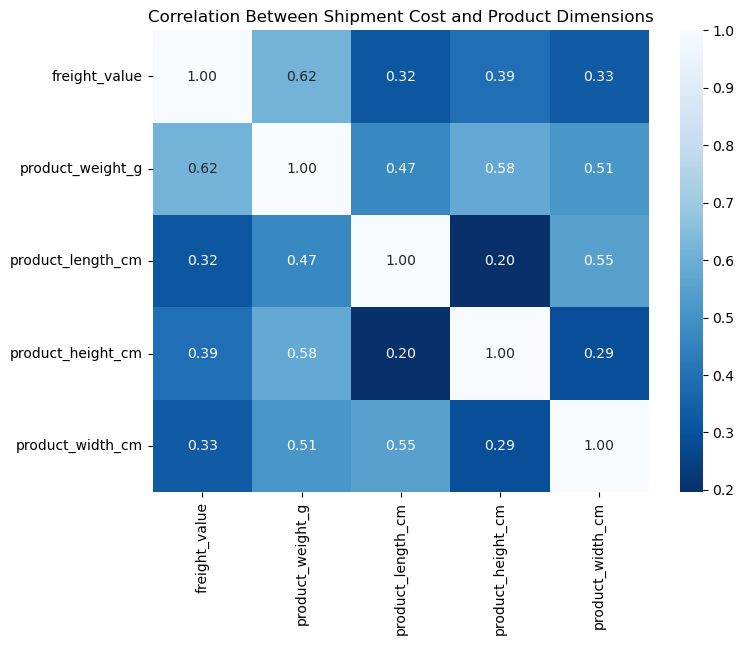

,Freight Category,Avg Weight (g),Median Weight (g),Avg Length (cm),Median Length (cm),Avg Height (cm),Median Height (cm),Avg Width (cm),Median Width (cm),Count
0,Low (0-20),1099.99,500.0,27.44,22.0,13.97,12.0,21.01,18.0,"71,015"
1,Moderate (20-50),3598.73,1833.0,35.14,30.0,20.77,16.0,26.88,23.0,"23,454"
2,High (50-100),9408.00,8217.0,45.04,41.0,32.85,27.0,34.03,32.0,"3,569"
3,Very High (100-200),18087.85,17350.0,58.33,57.0,48.37,49.0,45.30,45.0,552
4,Extreme (>200),22351.00,26400.0,66.20,56.0,53.85,55.5,48.40,49.5,60


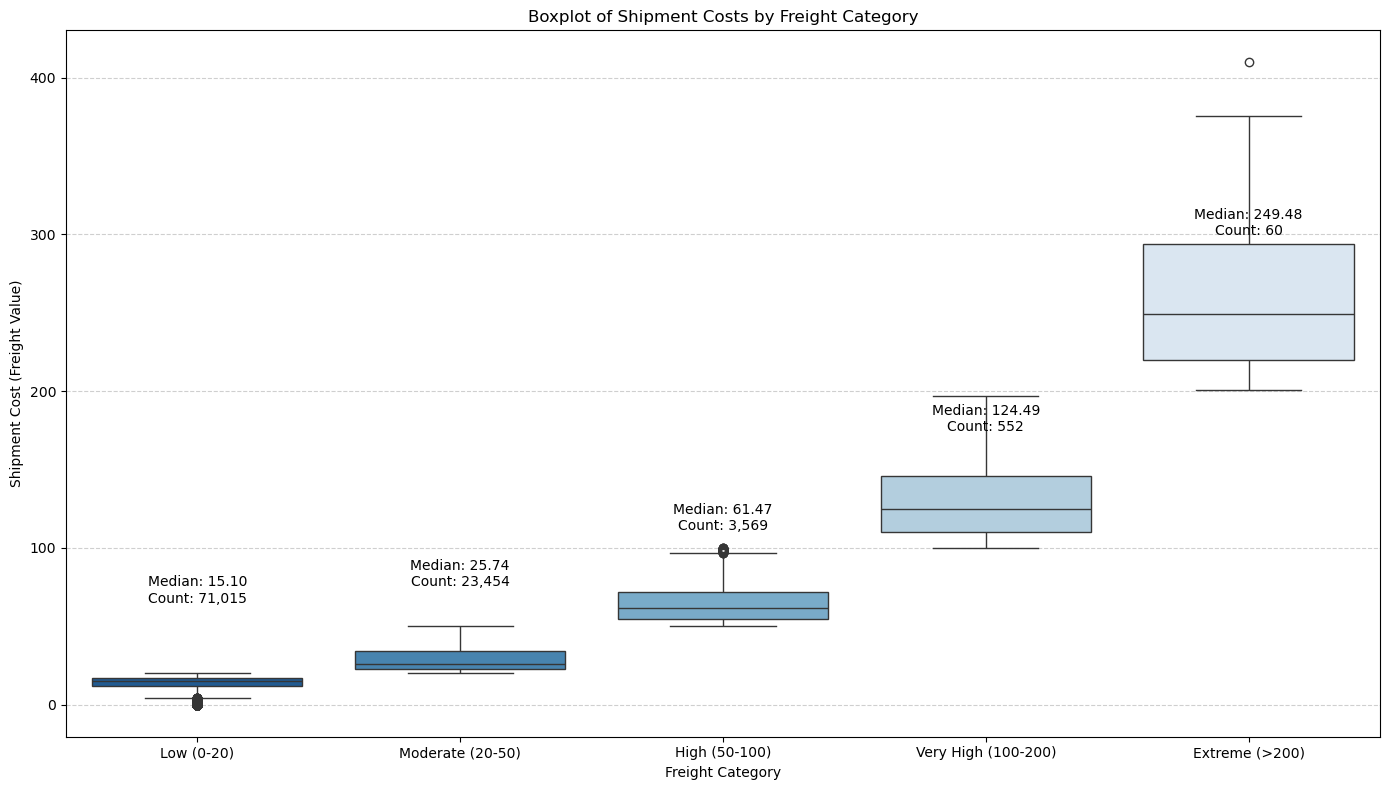

In [36]:
# Shipment Cost vs Product Dimensions

# Drop nulls for relevant columns
shipment_df = merged_df[['freight_value', 'product_weight_g', 'product_length_cm', 
                         'product_height_cm', 'product_width_cm']].dropna()

# Correlation Analysis
correlation_matrix = shipment_df.corr()
print("Correlation Matrix:\n")
# Limit decimals to 2 for correlation matrix
display(correlation_matrix.round(2))

# Heatmap for correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues_r', fmt=".2f")
plt.title('Correlation Between Shipment Cost and Product Dimensions')
plt.show()


# Group Freight Values into Categories
shipment_df['freight_category'] = pd.cut(
    shipment_df['freight_value'],
    bins=[0, 20, 50, 100, 200, shipment_df['freight_value'].max()],
    labels=['Low (0-20)', 'Moderate (20-50)', 'High (50-100)', 'Very High (100-200)', 'Extreme (>200)'],
    include_lowest=True
)

# Summary Statistics by Freight Category
grouped_stats = shipment_df.groupby('freight_category', observed=False).agg({
    'product_weight_g': ['mean', 'median'],
    'product_length_cm': ['mean', 'median'],
    'product_height_cm': ['mean', 'median'],
    'product_width_cm': ['mean', 'median'],
    'freight_value': ['count']
}).reset_index()

# Flatten column names for easier access
grouped_stats.columns = ['Freight Category', 'Avg Weight (g)', 'Median Weight (g)', 
                         'Avg Length (cm)', 'Median Length (cm)', 
                         'Avg Height (cm)', 'Median Height (cm)', 
                         'Avg Width (cm)', 'Median Width (cm)', 'Count']

# Apply rounding to all numeric columns (excluding 'Count') to 2 decimal places
numeric_columns = ['Avg Weight (g)', 'Median Weight (g)', 'Avg Length (cm)', 'Median Length (cm)', 
                   'Avg Height (cm)', 'Median Height (cm)', 'Avg Width (cm)', 'Median Width (cm)']
for col in numeric_columns:
    grouped_stats[col] = grouped_stats[col].apply(lambda x: round(x, 2))

# Add commas to 'Count' column for better readability
grouped_stats['Count'] = grouped_stats['Count'].apply(lambda x: f"{x:,}")

# Display the renamed and formatted table
display(grouped_stats)

# Boxplot for Freight Costs with Labels
plt.figure(figsize=(14, 8))
sns.boxplot(x='freight_category', y='freight_value', data=shipment_df, palette='Blues_r', hue='freight_category', legend=False)

# Add median and order count labels
for category in shipment_df['freight_category'].cat.categories:
    category_data = shipment_df[shipment_df['freight_category'] == category]
    median_value = category_data['freight_value'].median()
    order_count = len(category_data)
    plt.text(
        x=shipment_df['freight_category'].cat.categories.get_loc(category), 
        y=median_value + 50,  # Space above the median
        s=f"Median: {median_value:.2f}\nCount: {order_count:,}", 
        ha='center', color='black', fontsize=10
    )

plt.title('Boxplot of Shipment Costs by Freight Category')
plt.xlabel('Freight Category')
plt.ylabel('Shipment Cost (Freight Value)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()  # Ensures no clipping of labels or figure elements
plt.show()

### Shipment Cost vs Product Dimensions

**Key Insights**:
- **Correlation Insights:**
  - **Freight Value** is strongly correlated with **product weight** (**0.62**) and **product dimensions** (**length, height, width**), indicating that larger and heavier products tend to have higher shipping costs.
  
- **Freight Category Analysis:**
  - **Low (0-20)** freight category accounts for the majority of shipments (**71,015 orders**), with lower average weights and dimensions.
  - **High (50-100)** and **Very High (100-200)** freight categories have significantly higher average weights and dimensions, reflecting the increased shipping costs for larger or heavier items. The relatively low order volume in these categories suggests that they are specialized or less frequent but costly.

Total Orders: 99441
Returned/Refunded Orders: 625
Return & Refund Rate: 0.63%

Top Categories by Return Rate:


,Product Category,Return Count,Total Orders,Return Rate (%)
23,diapers_and_hygiene,1,27,3.70
25,dvds_blu_ray,2,59,3.39
8,books_general_interest,7,509,1.38
34,fixed_telephony,3,217,1.38
45,home_appliances_2,3,233,1.29
56,musical_instruments,8,624,1.28
63,small_appliances,8,627,1.28
19,construction_tools_safety,2,162,1.23
71,Unknown,16,1422,1.13
21,costruction_tools_garden,2,187,1.07


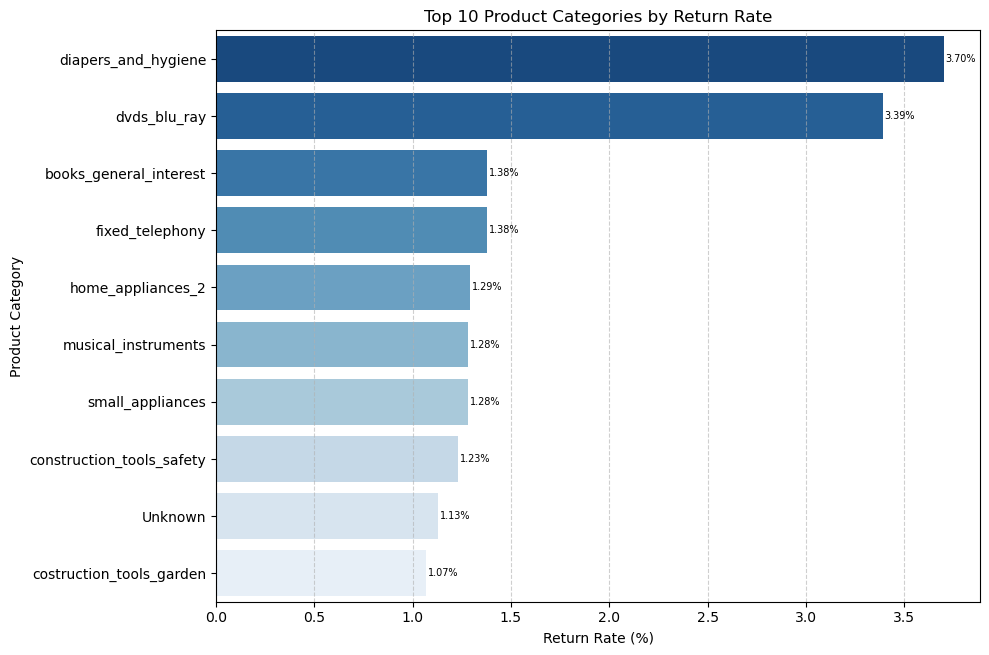

In [37]:
# Return & Refund Rates Analysis

# Extract relevant columns and filter for returned or refunded orders
returned_refunded_category_df = merged_df[merged_df['order_status'].isin(['returned', 'canceled'])]

# Apply observed=False to avoid the FutureWarning
category_return_stats = returned_refunded_category_df.groupby('product_category_name', observed=False).agg({
    'order_id': 'count'
}).rename(columns={'order_id': 'Return Count'}).reset_index()

# Add total orders per category and calculate return rate
total_category_orders = merged_df.groupby('product_category_name', observed=False)['order_id'].count().reset_index()
total_category_orders.rename(columns={'order_id': 'Total Orders'}, inplace=True)

# Merge dataframes and calculate return rate
category_return_stats = category_return_stats.merge(total_category_orders, on='product_category_name', how='left')
category_return_stats['Return Rate (%)'] = (category_return_stats['Return Count'] / category_return_stats['Total Orders']) * 100

# Limit decimals in 'Return Rate (%)' to 2 decimal places
category_return_stats['Return Rate (%)'] = category_return_stats['Return Rate (%)'].apply(lambda x: round(x, 2))

# Get top n categories based on return rate
top_categories_df = category_return_stats.nlargest(10, 'Return Rate (%)')

# Display overall Return & Refund Rate
total_orders = merged_df['order_id'].nunique()
returned_refunded_count = returned_refunded_category_df['order_id'].nunique()
return_refund_rate = (returned_refunded_count / total_orders) * 100
print(f"Total Orders: {total_orders}\nReturned/Refunded Orders: {returned_refunded_count}\nReturn & Refund Rate: {return_refund_rate:.2f}%")

# Rename 'product_category_name' to 'Product Category'
category_return_stats.rename(columns={'product_category_name': 'Product Category'}, inplace=True)
top_categories_df.rename(columns={'product_category_name': 'Product Category'}, inplace=True)

# Display the top categories table
print("\nTop Categories by Return Rate:")
display(top_categories_df)

# Return & Refund Rates Bar Plot

top_categories_df['Product Category'] = top_categories_df['Product Category'].astype(str)

# Copy the relevant data to a new dataframe for plotting
top_categories_sorted = top_categories_df.sort_values(by='Return Rate (%)', ascending=False)

# Visualization: Top 10 Categories by Return Rate
plt.figure(figsize=(10, 7))

# Create the barplot with hue set to 'Product Category' and legend=False to suppress the warning
sns.barplot(
    x='Return Rate (%)', 
    y='Product Category', 
    data=top_categories_sorted, 
    palette='Blues_r', 
    hue='Product Category',  # Adding hue to avoid warning
    legend=False  # Suppressing the legend
)

# Add labels to bars (adjust position to bring labels closer)
for index, row in top_categories_sorted.iterrows():
    plt.text(
        row['Return Rate (%)'] + 0.01,  # Adjust position for labels
        row['Product Category'],  # Correctly align with category names
        f"{row['Return Rate (%)']:.2f}%", 
        color='black', 
        va='center', 
        fontsize=7
    )

# Formatting
plt.title('Top 10 Product Categories by Return Rate')
plt.xlabel('Return Rate (%)')
plt.ylabel('Product Category')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid warning
plt.show()

### Return & Refund Rates Analysis

**Key Insights:**
- **Return & Refund Rate:** The overall rate of returned or refunded orders stands at **0.63%**, which is quite low. This indicates that the majority of transactions are satisfactory to the customers and do not require returns or refunds.
  
- **Top Categories with High Return Rates:**
  - **Diapers and Hygiene** has the highest return rate at **3.7%**, which could suggest either a mismatch between customer expectations and product quality or issues with sizing/fit.
  - **DVDs & Blu-Ray** and **Fixed Telephony** categories also show significant return rates (**3.39%** and **1.38%**, respectively), which could indicate issues like product defects, compatibility issues, or customer dissatisfaction.
  - Categories like **Books (General Interest)** and **Home Appliances** show return rates around **1.28%** to **1.38%**, which is still higher than average, possibly due to factors like damaged goods or mismatch with customer expectations.

## Payments


Payment Methods Distribution:


,Payment Method,Count,Percentage (%)
0,credit_card,"75,387",75.8
1,boleto,"19,784",19.9
2,voucher,"2,739",2.8
3,debit_card,"1,527",1.5
4,Unknown,4,0.0


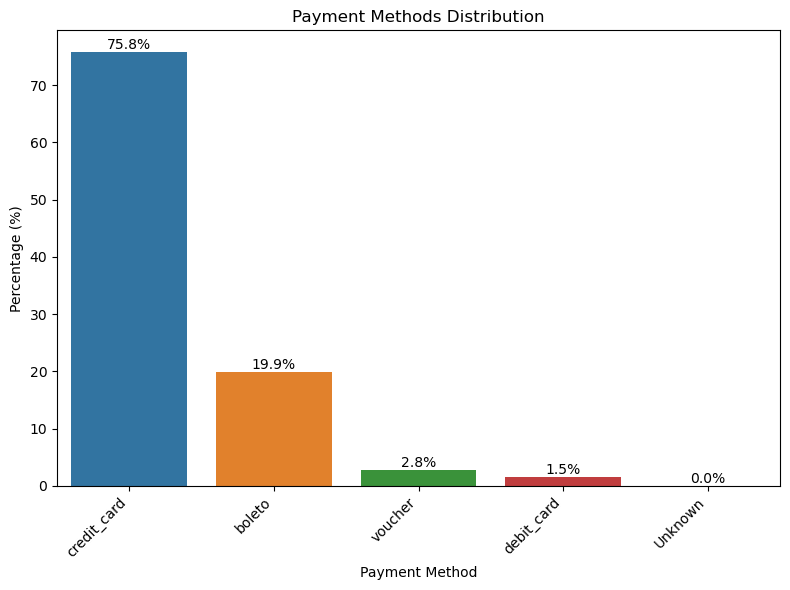

In [38]:
# Payment Methods Distribution

# Extract relevant columns for payment method analysis
payment_method_df = merged_df[['order_id', 'payment_type']].copy()

# Convert 'payment_type' to a string type to avoid categorical issues
payment_method_df.loc[:, 'payment_type'] = payment_method_df['payment_type'].astype(str)

# Rename undefined or 'not defined' payment methods to 'Unknown'
payment_method_df.loc[:, 'payment_type'] = payment_method_df['payment_type'].replace(['nan', 'not_defined'], 'Unknown')

# Calculate the distribution of payment methods
payment_method_distribution = payment_method_df['payment_type'].value_counts().reset_index()
payment_method_distribution.columns = ['Payment Method', 'Count']

# Add a percentage column and limit decimals
total_count = payment_method_distribution['Count'].sum()
payment_method_distribution['Percentage (%)'] = round((payment_method_distribution['Count'] / total_count) * 100, 1)

# Format count numbers with commas
payment_method_distribution['Count'] = payment_method_distribution['Count'].apply(lambda x: f"{x:,}")

# Display the payment method distribution table
print("\nPayment Methods Distribution:")
display(payment_method_distribution)

# Visualization: Bar chart for Payment Methods Distribution
plt.figure(figsize=(8, 6))

# Create the bar chart
sns.barplot(
    x='Payment Method', 
    y='Percentage (%)', 
    data=payment_method_distribution,
    hue="Payment Method"
)

# Add labels to bars (display percentage on top of bars)
for index, row in payment_method_distribution.iterrows():
    plt.text(
        index, 
        row['Percentage (%)'] + 0.5, 
        f"{row['Percentage (%)']}%", 
        color='black', 
        ha='center', 
        fontsize=10
    )

# Title and labels
plt.title('Payment Methods Distribution')
plt.xlabel('Payment Method')
plt.ylabel('Percentage (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

### Payment Methods Distribution

**Key Insights:**
- **Credit Card** is the most popular payment method, accounting for **75.8%** of transactions. This indicates a strong preference for using credit cards among customers.
  
- **Boleto** is the second most used method, with **19.9%** of orders paid through this option. This suggests that boleto is still a preferred method for many, especially in Brazil, where it is widely used for online purchases.
  
- **Voucher** and **Debit Card** are less common, representing only **2.8%** and **1.5%** of transactions, respectively. This could indicate that customers using these methods may be a smaller segment or prefer alternative payment methods for various reasons.

- **Unknown** represents a negligible portion of payments, making up **0.0%** of the total, which could suggest either incomplete data or a very small number of transactions with unidentified payment methods.


Payment Method Profitability Analysis:


,Total Product Price,Total Freight Value,Total Revenue,Average Order Value,Profitability Ratio
payment_type,,,,,
credit_card,"9,881,609.06","1,525,604.93","11,407,213.99",152.33,"74,883"
boleto,"2,114,229.98","387,722.13","2,501,952.11",127.56,"19,614"
voucher,"261,259.65","50,841.41","312,101.06",117.86,"2,648"
debit_card,"171,252.63","29,072.01","200,324.64",131.79,"1,520"
Unknown,44.99,2.83,47.82,47.82,1


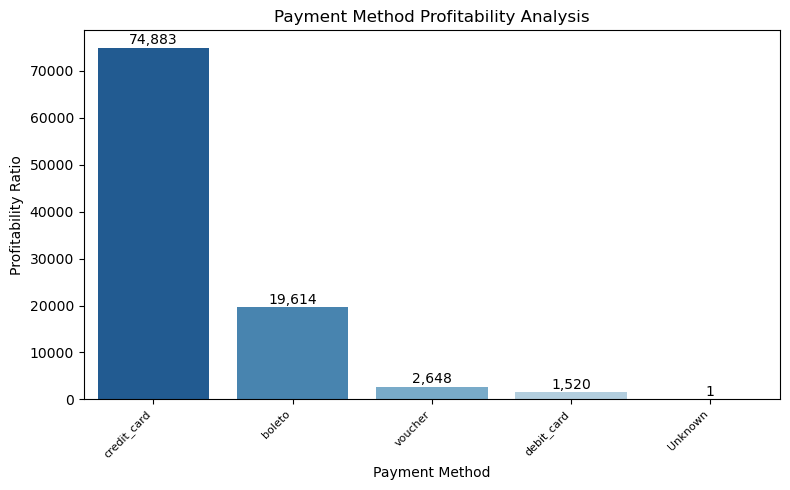

In [39]:
# Payment Method Profitability Analysis

# Extract relevant columns and preprocess
payment_method_profit_df = merged_df[['order_id', 'payment_type', 'product_price', 'freight_value']].copy()
payment_method_profit_df['payment_type'] = payment_method_profit_df['payment_type'].astype(str).replace(
    ['nan', 'not_defined'], 'Unknown')
payment_method_profit_df['product_price'] = payment_method_profit_df['product_price'].replace(
    {',': ''}, regex=True).astype(float)
payment_method_profit_df['freight_value'] = payment_method_profit_df['freight_value'].replace(
    {',': ''}, regex=True).astype(float)

# Calculate revenue and AOV
payment_method_profit_df['Total Order Value'] = payment_method_profit_df['product_price'] + payment_method_profit_df['freight_value']
payment_method_revenue = payment_method_profit_df.groupby('payment_type').agg({
    'product_price': 'sum',
    'freight_value': 'sum'
}).reset_index()
payment_method_revenue['Total Revenue'] = payment_method_revenue['product_price'] + payment_method_revenue['freight_value']
payment_method_aov = payment_method_profit_df.groupby('payment_type')['Total Order Value'].mean().reset_index()
payment_method_aov.columns = ['payment_type', 'Average Order Value']

# Merge and calculate profitability ratio
payment_method_profitability = pd.merge(payment_method_revenue, payment_method_aov, on='payment_type')
payment_method_profitability['Profitability Ratio'] = payment_method_profitability['Total Revenue'] / payment_method_profitability['Average Order Value']
payment_method_profitability = payment_method_profitability.sort_values(by='Profitability Ratio', ascending=False)

# Rename columns for better clarity
payment_method_profitability.rename(columns={
    'product_price': 'Total Product Price',
    'freight_value': 'Total Freight Value'
}, inplace=True)

# Format columns for display
payment_method_profitability['Total Product Price'] = payment_method_profitability['Total Product Price'].apply(lambda x: f"{x:,.2f}")
payment_method_profitability['Total Freight Value'] = payment_method_profitability['Total Freight Value'].apply(lambda x: f"{x:,.2f}")
payment_method_profitability['Total Revenue'] = payment_method_profitability['Total Revenue'].apply(lambda x: f"{x:,.2f}")
payment_method_profitability['Average Order Value'] = payment_method_profitability['Average Order Value'].apply(lambda x: f"{x:,.2f}")

# Set payment_type as index for proper alignment
payment_method_profitability.set_index('payment_type', inplace=True)

# Create a copy for display formatting
display_df = payment_method_profitability.copy()
display_df['Profitability Ratio'] = display_df['Profitability Ratio'].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else 'NaN')

# Display the formatted dataframe
print("\nPayment Method Profitability Analysis:")
display(display_df)


# Visualization
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=payment_method_profitability.index,  # Use index for x-axis
    y='Profitability Ratio', 
    data=payment_method_profitability, 
    palette='Blues_r'
)

# Calculate a proportional offset based on the y-axis range
y_max = payment_method_profitability['Profitability Ratio'].max()
offset = y_max * 0.002  # .2% of the maximum value as the offset

# Add labels to bars using the positions from ax.patches
for bar, (_, row) in zip(ax.patches, payment_method_profitability.iterrows()):
    # Get the center of the bar and its height
    x_pos = bar.get_x() + bar.get_width() / 2  # Center the label horizontally
    y_pos = bar.get_height() + offset  # Add proportional offset
    ax.text(
        x=x_pos,  # Numeric x-coordinate
        y=y_pos,  # Adjusted y-coordinate
        s=f"{row['Profitability Ratio']:,.0f}",  # Format with commas
        ha='center',  # Center the text horizontally
        va='bottom',  # Align text to the bottom
        fontsize=10, 
        color='black'
    )

# Formatting
plt.title('Payment Method Profitability Analysis', fontsize=12)
plt.xlabel('Payment Method', fontsize=10)
plt.ylabel('Profitability Ratio', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

### Payment Method Profitability Analysis

**Key Insights:**
- **Credit Card** payments have the highest profitability, with a **profitability ratio** of **74,883** and an **average order value** of **R$ 152.33**. This suggests that credit card transactions generate significantly more revenue and profit compared to other payment methods.
  
- **Boleto** follows with a **profitability ratio** of **19,614**, and an **average order value** of **R$ 127.56**, indicating that boleto transactions, while less profitable than credit cards, still contribute substantially to total revenue.

- **Voucher** and **Debit Card** transactions have lower profitability ratios, **2,648** and **1,520** respectively, and also show a lower average order value (**R$ 117.86** and **R$ 131.79**). This indicates that while these payment methods are used, they yield smaller profit margins.

- The **Unknown** category shows negligible profitability, with a **profitability ratio** of **1**, which may reflect a very limited number of transactions or incomplete data.

## Marketing

Total MQLs: 8000
Converted Leads: 842
Overall Conversion Rate: 10.53%

Proportions by Business Segment:


,Business Segment,Converted Leads,Proportion (%)
17,home_decor,105,12.47
15,health_beauty,93,11.05
6,car_accessories,77,9.14
19,household_utilities,71,8.43
8,construction_tools_house_garden,69,8.19
1,audio_video_electronics,64,7.60
7,computers,34,4.04
25,pet,30,3.56
11,food_supplement,28,3.33
10,food_drink,26,3.09



Proportions by Lead Type:


,Lead Type,Converted Leads,Proportion (%)
4,online_medium,332,39.43
3,online_big,126,14.96
0,industry,123,14.61
1,offline,104,12.35
5,online_small,77,9.14
2,online_beginner,57,6.77
6,online_top,14,1.66
8,Unknown,6,0.71
7,other,3,0.36



Proportions by Lead Behaviour Profile:


,Lead Behaviour Profile,Converted Leads,Proportion (%)
0,cat,407,48.34
9,Unknown,177,21.02
2,eagle,123,14.61
8,wolf,95,11.28
5,shark,24,2.85
1,"cat, wolf",8,0.95
3,"eagle, cat",3,0.36
4,"eagle, wolf",3,0.36
6,"shark, cat",1,0.12
7,"shark, wolf",1,0.12



Proportions by Origin:


,Origin,Converted Leads,Proportion (%)
4,organic_search,271,32.19
7,paid_search,195,23.16
10,unknown,179,21.26
9,social,75,8.91
1,direct_traffic,56,6.65
8,referral,24,2.85
3,email,15,1.78
0,Unknown,14,1.66
2,display,6,0.71
5,other,4,0.48


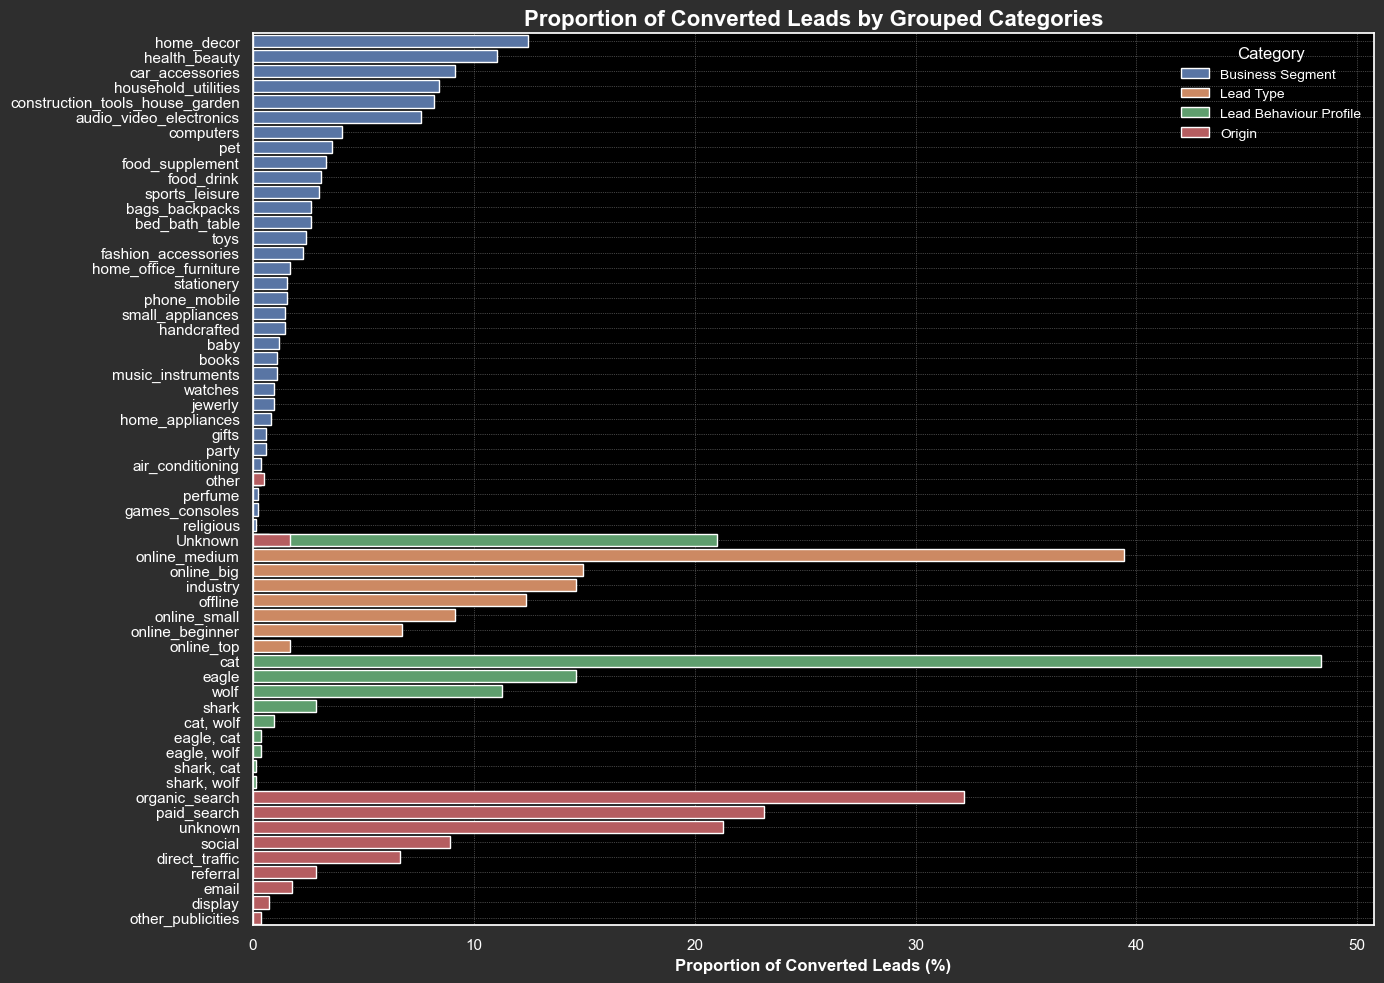

In [40]:
# Seller Lead Conversion Analysis

# Ensure proper merging of MQL and Closed Deals datasets
mql_df['mql_id'] = mql_df['mql_id'].astype(str)
closed_deals_df['mql_id'] = closed_deals_df['mql_id'].astype(str)

# Merge MQL and Closed Deals datasets on 'mql_id' (recreate merged_leads)
merged_leads = pd.merge(mql_df, closed_deals_df, on='mql_id', how='left')

# Add a column to identify converted leads
merged_leads['is_converted'] = merged_leads['won_date'].notnull().astype(int)

# Calculate total MQLs and converted leads
total_mqls = merged_leads['mql_id'].nunique()
converted_leads = merged_leads['is_converted'].sum()
conversion_rate = (converted_leads / total_mqls) * 100

print(f"Total MQLs: {total_mqls}")
print(f"Converted Leads: {converted_leads}")
print(f"Overall Conversion Rate: {conversion_rate:.2f}%")

# Calculate Proportions for Business Segment, Lead Type, Lead Behaviour Profile, and Origin
business_segment_df = (
    merged_leads.groupby('business_segment', observed=False)['is_converted']
    .sum()
    .reset_index()
    .sort_values(by='is_converted', ascending=False)
)
business_segment_df.columns = ['Business Segment', 'Converted Leads']
business_segment_df['Proportion (%)'] = (business_segment_df['Converted Leads'] / converted_leads * 100).round(2)

lead_type_df = (
    merged_leads.groupby('lead_type', observed=False)['is_converted']
    .sum()
    .reset_index()
    .sort_values(by='is_converted', ascending=False)
)
lead_type_df.columns = ['Lead Type', 'Converted Leads']
lead_type_df['Proportion (%)'] = (lead_type_df['Converted Leads'] / converted_leads * 100).round(2)

lead_behaviour_df = (
    merged_leads.groupby('lead_behaviour_profile', observed=False)['is_converted']
    .sum()
    .reset_index()
    .sort_values(by='is_converted', ascending=False)
)
lead_behaviour_df.columns = ['Lead Behaviour Profile', 'Converted Leads']
lead_behaviour_df['Proportion (%)'] = (lead_behaviour_df['Converted Leads'] / converted_leads * 100).round(2)

origin_df = (
    merged_leads.groupby('origin', observed=False)['is_converted']
    .sum()
    .reset_index()
    .sort_values(by='is_converted', ascending=False)
)
origin_df.columns = ['Origin', 'Converted Leads']
origin_df['Proportion (%)'] = (origin_df['Converted Leads'] / converted_leads * 100).round(2)

# Display DataFrames
from IPython.display import display

print("\nProportions by Business Segment:")
display(business_segment_df)

print("\nProportions by Lead Type:")
display(lead_type_df)

print("\nProportions by Lead Behaviour Profile:")
display(lead_behaviour_df)

print("\nProportions by Origin:")
display(origin_df)


# Visualisation (Clustered Bar Charts)

# Combine DataFrames for Visualization
combined_data = pd.concat([
    business_segment_df.rename(columns={"Business Segment": "Subcategory"}).assign(Category="Business Segment"),
    lead_type_df.rename(columns={"Lead Type": "Subcategory"}).assign(Category="Lead Type"),
    lead_behaviour_df.rename(columns={"Lead Behaviour Profile": "Subcategory"}).assign(Category="Lead Behaviour Profile"),
    origin_df.rename(columns={"Origin": "Subcategory"}).assign(Category="Origin")
])

# Ensure Category is treated as a categorical variable with a defined order before plotting
combined_data['Category'] = pd.Categorical(
    combined_data['Category'],
    categories=["Business Segment", "Lead Type", "Lead Behaviour Profile", "Origin"],
    ordered=True
)

# Sort data by Category and Proportion (%) descending
combined_data = combined_data.sort_values(by=["Category", "Proportion (%)"], ascending=[True, False])


# Visualization: Grouped Bar Chart

# Set style
plt.style.use("dark_background")
sns.set(style="darkgrid")

# Create the plot
plt.figure(figsize=(14, 10))  # Adjusted for grouped visualization
sns.barplot(
    data=combined_data,
    x="Proportion (%)",
    y="Subcategory",
    hue="Category",
    dodge=False,  # Ensures grouped but not stacked bars
)

# Title and Labels
plt.title("Proportion of Converted Leads by Grouped Categories", fontsize=16, color='white', fontweight='bold')  # Set title color to white
plt.xlabel("Proportion of Converted Leads (%)", fontsize=12, color='white', fontweight='bold')  # Set xlabel color to white
plt.ylabel("", fontsize=12, color='white', fontweight='bold')  # Set ylabel color to white (if necessary)

# Adjust y-axis title and ticks color
plt.gca().yaxis.label.set_color('white')  # Set y-axis title color to white
plt.gca().tick_params(axis='y', colors='white')  # Set y-axis ticks color to white
plt.gca().tick_params(axis='x', colors='white')  # Set x-axis ticks color to white

# Legend adjustments
legend = plt.legend(title="Category", fontsize=10, title_fontsize=12, loc='upper right', frameon=False, labelcolor='white')
legend.get_title().set_color('white')  # Set legend title color to white

# Adjust background color of the axes and figure
plt.gca().set_facecolor('black')  # Set axes background to black
plt.gcf().set_facecolor('#2e2e2e')  # Set figure background to a lighter dark color

# Adjust gridlines to be dotted and retain horizontal gridlines
plt.grid(True, linestyle=':', linewidth=0.5, color='gray', which='major')  # Dotted gridlines

# Tight layout and saving
plt.tight_layout()
plt.show()


# Reset the background to default
plt.rcParams.update(plt.rcParamsDefault)

### Seller Lead Conversion Analysis

**Key Insights:**
- The overall **conversion rate** is **10.53%**, indicating a modest success in converting seller leads into actual sellers on the platform.

- The **Home Decor** segment has the highest conversion rate with **12.47%** of converted leads, followed by **Health & Beauty** (**11.05%**) and **Car Accessories** (**9.14%**). These categories are more successful in converting leads into active sellers.

- The **Lead Type** analysis shows that **Online Medium** leads contribute the most to conversions (**39.43%**), followed by **Online Big** (**14.96%**) and **Industry** leads (**14.61%**). This suggests that online marketing efforts are more effective in converting leads into sellers.

- The **Lead Behaviour Profile** shows that **Cat** leads dominate conversions (**48.34%**), followed by **Eagle** leads (**14.61%**) and **Wolf** leads (**11.28%**). This insight helps to understand the most responsive lead profiles in terms of seller conversion.

- **Organic Search** is the leading origin for converted leads (**32.19%**), followed by **Paid Search** (**23.16%**) and **Unknown** sources (**21.26%**). This highlights the importance of search engine visibility in converting seller leads.

- Some segments, such as **Religious** (**0.12%**) and **Games Consoles** (**0.24%**), have very low conversion rates, indicating that these categories may need more targeted strategies to improve seller conversion.

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validation scores: [0.90932983 0.91458607 0.91151993 0.91239597 0.91761613]
Mean cross-validation score: 0.913089585293579
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1451
           1       0.16      0.26      0.20       149

    accuracy                           0.80      1600
   macro avg       0.54      0.56      0.54      1600
weighted avg       0.85      0.80      0.82      1600

ROC-AUC Score: 0.5595423660608976
Confusion Matrix:
[[1244  207]
 [ 110   39]]


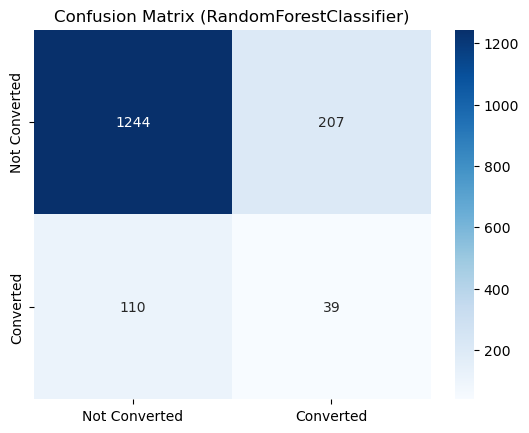

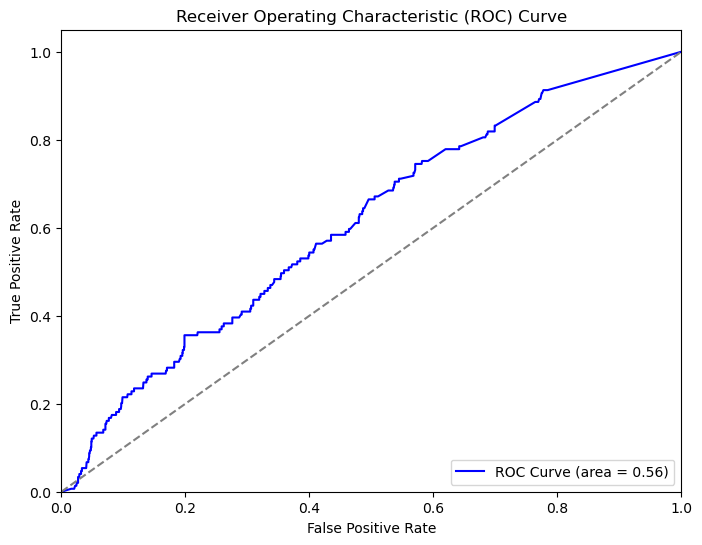

Precision-Recall AUC Score: 0.1315641996557746


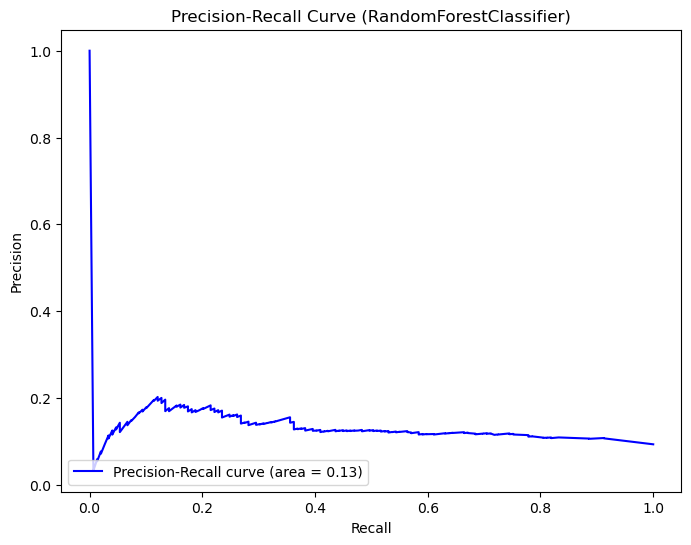

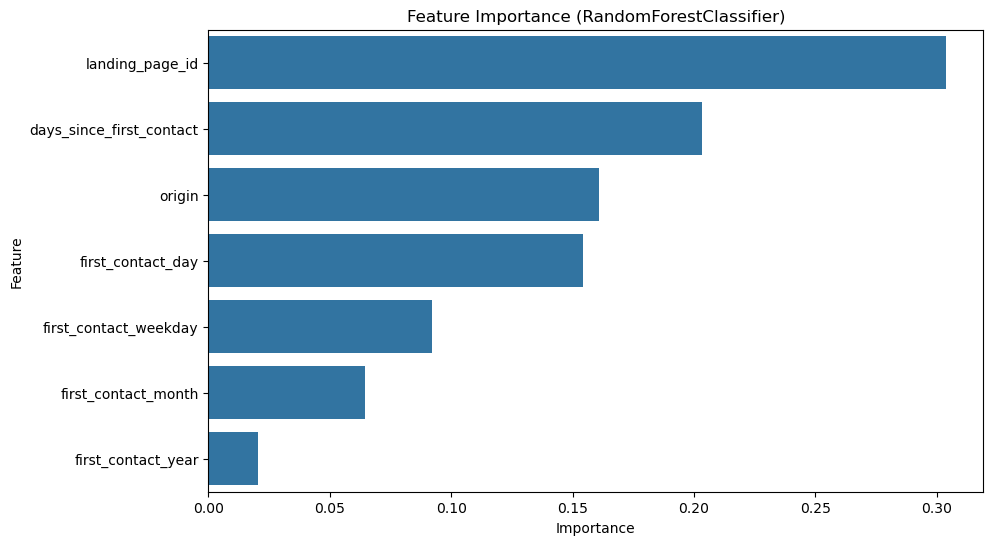

Feature Importance Table:
                    Feature  Importance
0           landing_page_id    0.304053
6  days_since_first_contact    0.203428
1                    origin    0.161062
3         first_contact_day    0.154166
4     first_contact_weekday    0.092081
2       first_contact_month    0.064642
5        first_contact_year    0.020568


In [41]:
# Seller Classification Analysis (Random Forest Classifier)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Assuming mql_df and closed_deals_df are already loaded

# Step 1: Feature Engineering (from datetime columns)
mql_df['first_contact_month'] = mql_df['first_contact_date'].dt.month
mql_df['first_contact_day'] = mql_df['first_contact_date'].dt.day
mql_df['first_contact_weekday'] = mql_df['first_contact_date'].dt.weekday
mql_df['first_contact_year'] = mql_df['first_contact_date'].dt.year
mql_df['days_since_first_contact'] = (pd.to_datetime('today') - mql_df['first_contact_date']).dt.days

# Merge the mql_df with closed_deals_df to get the 'first_contact_date' in closed_deals_df
mql_merged_df = pd.merge(closed_deals_df, mql_df[['mql_id', 'first_contact_date']], on='mql_id', how='left')

# Calculate 'days_to_convert' using the 'first_contact_date' from mql_df
mql_merged_df['days_to_convert'] = (mql_merged_df['won_date'] - mql_merged_df['first_contact_date']).dt.days

# Step 2: Label Creation (is_converted)
mql_df['is_converted'] = mql_df['mql_id'].isin(closed_deals_df['mql_id']).astype(int)

# Step 3: Prepare the Data
X = mql_df.drop(['mql_id', 'first_contact_date', 'is_converted'], axis=1)  # Features
y = mql_df['is_converted']  # Target

# Label Encoding for categorical variables
X = X.apply(LabelEncoder().fit_transform)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Undersample Majority Class (Class 0) and Oversample Minority Class (Class 1)
# Concatenate training data back together
train_data = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
minority_class = train_data[train_data['is_converted'] == 1]
majority_class = train_data[train_data['is_converted'] == 0]

# Oversample the minority class
minority_class_oversampled = resample(minority_class, 
                                      replace=True,    # With replacement
                                      n_samples=len(majority_class),  # Match majority class size
                                      random_state=42)  # Reproducibility

# Combine the oversampled minority class with the majority class
train_data_balanced = pd.concat([majority_class, minority_class_oversampled])

# Split back into X and y
X_train_balanced = train_data_balanced.drop('is_converted', axis=1)
y_train_balanced = train_data_balanced['is_converted']

# Step 6: Train RandomForest Model with Class Weight Adjustment
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_balanced, y_train_balanced)

# Step 7: Best Hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Step 8: Cross-validation scores
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_balanced, y_train_balanced, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Step 9: Model Evaluation on Test Set
y_pred = grid_search.best_estimator_.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc}")

# Confusion Matrix (Text)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix Chart
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.title('Confusion Matrix (RandomForestClassifier)')
plt.show()

# Step 10: ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 11: Precision-Recall AUC Curve
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (RandomForestClassifier)')
plt.legend(loc="lower left")
plt.show()

# Step 12: Feature Importance Plot (from the best model)
feature_importances = grid_search.best_estimator_.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (RandomForestClassifier)')
plt.show()

# Display Feature Importance Table
print("Feature Importance Table:")
print(feature_importance_df)

### Seller Classification Analysis (Random Forest Classifier)

**Key Insights:**
- **Model Performance**:
  - **Mean CV Score**: **91.31%**. 
  - **Accuracy**: **80%**, but poor minority class performance (**F1-Score: 0.20**, **ROC-AUC: 0.56**).

- **Class-Specific Observations**:
  - **Class 0**: High precision (**92%**) and recall (**86%**).
  - **Class 1**: Low precision (**16%**) and recall (**26%**) due to class imbalance.

- **Feature Importance**:
  - Key drivers: `landing_page_id` (**30.41%**) and `days_since_first_contact` (**20.34%**).
  - Temporal features like `first_contact_day` (**15.42%**) also contribute significantly.

- **Challenges**:
  - Minority class prediction is weak (**Precision-Recall AUC: 0.13**).
  - Confusion matrix shows **110 false negatives** for Class 1.

- **Recommendations**:
  - Address imbalance using SMOTE or cost-sensitive learning.
  - Enhance features to improve minority class detection.
  - Test alternative models or ensemble methods.

## Product Analysis

Top 10 Products by Revenue:


,Product ID,Category Name,Total Revenue,Units Sold
1677355,bb50f2e236e5eea0100680137654686c,health_beauty,"61,245.00",187
980251,6cdd53843498f92890544667809f1595,health_beauty,"52,602.60",150
1922918,d6160fb7873f184099d9bc95e30376af,computers,"48,899.34",35
1883247,d1c427060a0f73f6b889a5c7c61f2ac4,computers_accessories,"43,638.62",318
1375135,99a4788cb24856965c36a24e339b6058,bed_bath_table,"38,711.36",439
562047,3dd2a17168ec895c781a9191c1e95ad7,computers_accessories,"38,084.60",254
349278,25c38557cf793876c5abdd5931f922db,baby,"37,851.42",37
860204,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,"37,123.90",62
757078,53b36df67ebb7c41585e8d54d6772e08,watches_gifts,"35,123.02",302
1889494,d285360f29ac7fd97640bf0baef03de0,watches_gifts,"31,423.91",122



Top 10 Categories by Revenue:


,Category Name,Total Revenue,Units Sold
43,health_beauty,"1,191,228.88","8,796"
70,watches_gifts,"1,167,468.75","5,601"
65,sports_leisure,"913,050.06","7,681"
7,bed_bath_table,"895,981.88","9,311"
15,computers_accessories,"779,711.44","6,660"
20,cool_stuff,"615,503.19","3,603"
39,furniture_decor,"600,933.62","6,355"
49,housewares,"561,526.56","5,829"
5,auto,"551,557.44","3,880"
69,toys,"464,511.66","3,861"


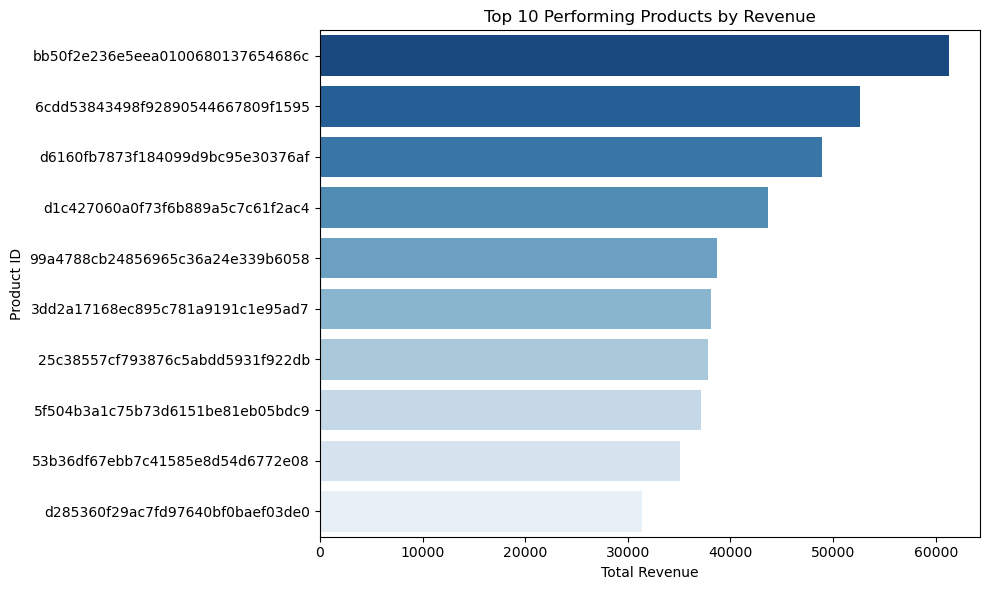

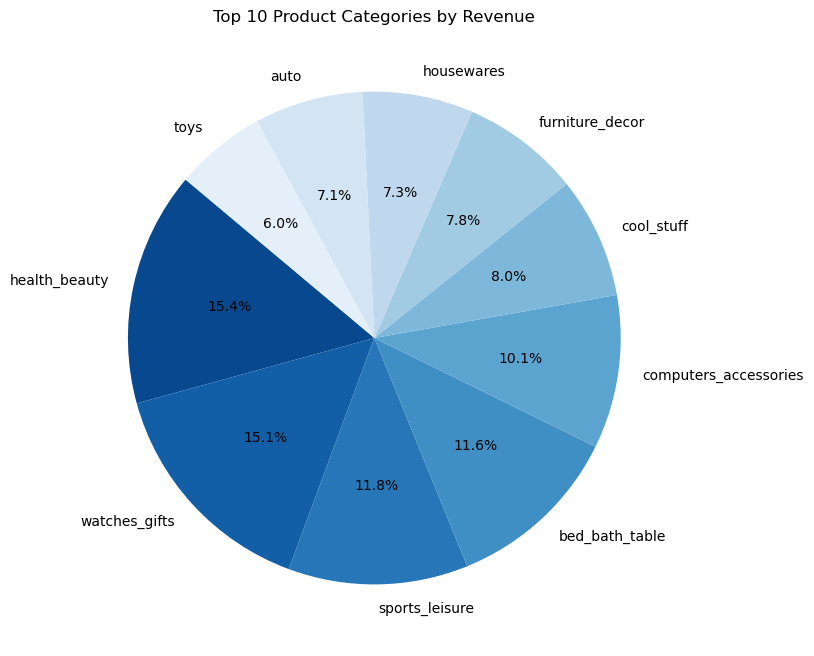

In [42]:
# Top Performing Products and Categories

# Disable scientific notation for tables
pd.options.display.float_format = '{:,.2f}'.format

# Calculate total revenue and units sold per product
product_analysis = (
    merged_df.groupby(['product_id', 'product_category_name'])
    .agg(total_revenue=('product_price', 'sum'), total_units_sold=('order_item_id', 'count'))
    .reset_index()
)

# Sort products by total revenue in descending order
top_products = product_analysis.sort_values(by='total_revenue', ascending=False)

# Calculate total revenue and units sold per category
category_analysis = (
    product_analysis.groupby('product_category_name')
    .agg(total_revenue=('total_revenue', 'sum'), total_units_sold=('total_units_sold', 'sum'))
    .reset_index()
    .sort_values(by='total_revenue', ascending=False)
)

# Rename columns for clarity
top_products.rename(columns={
    'product_id': 'Product ID',
    'product_category_name': 'Category Name',
    'total_revenue': 'Total Revenue',
    'total_units_sold': 'Units Sold'
}, inplace=True)

category_analysis.rename(columns={
    'product_category_name': 'Category Name',
    'total_revenue': 'Total Revenue',
    'total_units_sold': 'Units Sold'
}, inplace=True)

top_products['Units Sold'] = top_products['Units Sold'].apply(lambda x: f"{x:,}")
category_analysis['Units Sold'] = category_analysis['Units Sold'].apply(lambda x: f"{x:,}")

print("Top 10 Products by Revenue:")
display(top_products.head(10))

print("\nTop 10 Categories by Revenue:")
display(category_analysis.head(10))

# Visualization: Bar chart for top products
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_products.head(10),
    x='Total Revenue',
    y='Product ID',
    palette='Blues_r'
)
plt.title('Top 10 Performing Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product ID')
plt.tight_layout()
plt.show()


# Visualization: Pie chart for top categories
plt.figure(figsize=(8, 8))
top_categories = category_analysis.head(10)
plt.pie(
    top_categories['Total Revenue'],
    labels=top_categories['Category Name'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Blues_r', len(top_categories))
)
plt.title('Top 10 Product Categories by Revenue')
plt.show()

### Top Performing Products and Categories

**Key Insights:**
- The **top 10 products by revenue** are dominated by items from the **health & beauty** and **computers** categories, with the highest revenue generated by a **health & beauty** product (68,810.00) that sold 210 units.
- **Computers accessories** also perform strongly, with two products making it into the top 10, contributing significantly to overall revenue.
- **Category-wise**, **health & beauty** is the clear leader, generating **1,301,948.00** in revenue from 10,032 units sold, followed by **watches & gifts** with **1,254,323.00** in revenue from 6,213 units sold.
- **Bed & bath**, **sports & leisure**, and **computers accessories** categories also show strong performance, each generating over **1 million in revenue**.

**Recommendations:**
- Focus on **health & beauty** and **computers accessories** categories for marketing and inventory management, as they are driving significant revenue.
- Explore **watches & gifts** and **furniture & decor** for potential growth opportunities, given their strong sales performance.
- **Product diversification** within top-performing categories like **health & beauty** can help capture a larger share of the market.

Correlation between Review Score and Product Listing Metrics:


,Correlation with Review Score
product_name_lenght,-0.01
product_description_lenght,0.01
product_photos_qty,0.02
product_weight_g,-0.03
product_length_cm,-0.02
product_height_cm,-0.02
product_width_cm,-0.01



Optimal Ranges for Metrics by Category:


,Category,Name Length Mean,Name Length Std,Description Length Mean,Description Length Std,Photos Qty Mean,Photos Qty Std,Avg Review Score
0,agro_industry_and_commerce,46.24,10.12,892.55,711.10,2.48,2.07,4.02
1,air_conditioning,51.03,9.29,989.73,784.78,2.40,1.59,4.04
2,art,47.85,7.60,971.68,486.90,1.94,2.19,4.05
3,arts_and_craftmanship,46.91,11.76,814.36,495.37,3.77,2.22,4.14
4,audio,44.71,9.81,781.15,746.42,1.85,1.28,3.84
5,auto,52.60,8.25,888.36,671.81,2.56,1.74,4.10
6,baby,47.53,11.35,905.11,570.13,2.44,1.73,4.06
7,bed_bath_table,51.83,7.61,448.90,416.80,1.52,1.12,3.98
8,books_general_interest,41.36,11.03,1083.55,790.88,1.83,1.72,4.47
9,books_imported,47.06,9.73,688.31,786.70,1.83,1.87,4.38


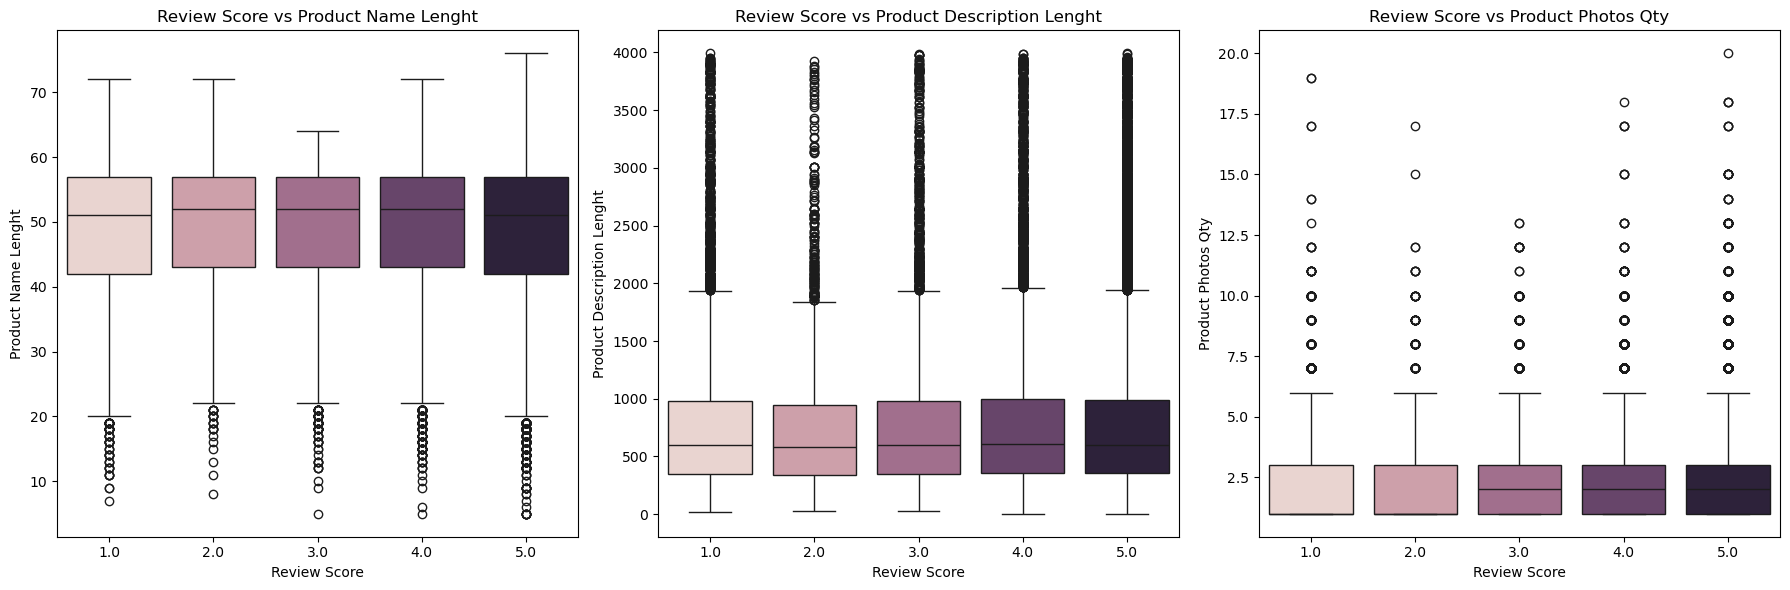

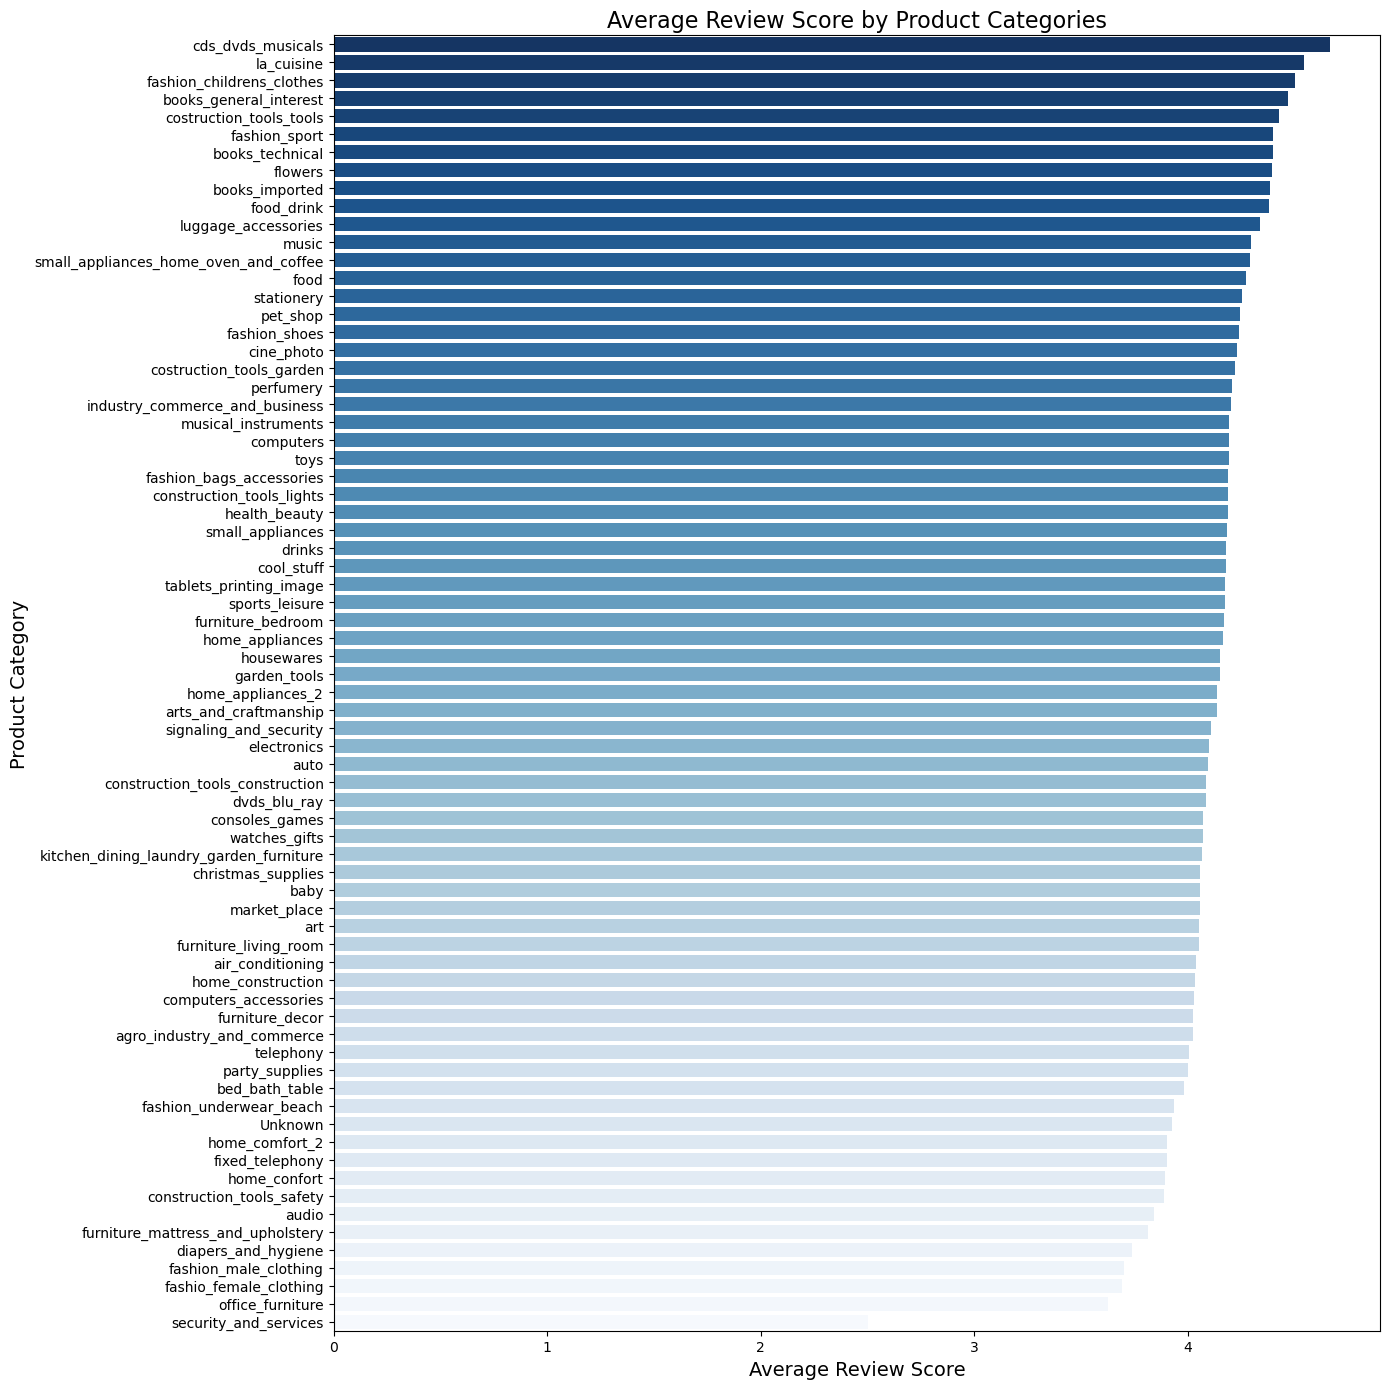

In [43]:
# Product Listing Quality Analysis

# Data Preparation
columns = [
    'review_score', 'product_category_name', 'product_name_lenght', 
    'product_description_lenght', 'product_photos_qty', 
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
]
listing_quality_df = merged_df[columns].dropna()

# Cast only numeric columns to numeric, leaving non-numeric columns untouched
listing_quality_df.update(listing_quality_df.select_dtypes(include=['number']).apply(pd.to_numeric, errors='coerce'))

# Correlation Table: Review score with metrics
numeric_columns = [
    'review_score', 'product_name_lenght', 'product_description_lenght', 
    'product_photos_qty', 'product_weight_g', 'product_length_cm', 
    'product_height_cm', 'product_width_cm'
]
correlation_table = listing_quality_df[numeric_columns].corr().loc['review_score', numeric_columns[1:]].to_frame(name="Correlation with Review Score")

# Optimal Ranges Table
optimal_ranges = listing_quality_df.groupby('product_category_name', observed=True).agg({
    'product_name_lenght': ['mean', 'std'],
    'product_description_lenght': ['mean', 'std'],
    'product_photos_qty': ['mean', 'std'],
    'review_score': 'mean'
}).reset_index()

# Rename columns for clarity
optimal_ranges.columns = ['Category', 'Name Length Mean', 'Name Length Std', 
                          'Description Length Mean', 'Description Length Std', 
                          'Photos Qty Mean', 'Photos Qty Std', 'Avg Review Score']

# Convert numeric columns to string with formatted floats
correlation_table["Correlation with Review Score"] = correlation_table["Correlation with Review Score"].apply(pd.to_numeric, errors='coerce').apply(lambda x: "{:.2f}".format(x))

# Ensure columns are numeric
optimal_ranges.iloc[:, 1:] = optimal_ranges.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Create a formatted version for display (optional)
formatted_optimal_ranges = optimal_ranges.copy()
# Iterate over columns starting from the second column
for col in formatted_optimal_ranges.columns[1:]:
    formatted_optimal_ranges[col] = formatted_optimal_ranges[col].apply(
        lambda x: f"{x:.2f}" if pd.notnull(x) else "NaN"
    ).astype(str)  # Ensure all values are treated as strings


# Display Tables
print("Correlation between Review Score and Product Listing Metrics:")
display(correlation_table)

print("\nOptimal Ranges for Metrics by Category:")
display(formatted_optimal_ranges)


# Boxplot: Review Score vs Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty']

for i, metric in enumerate(metrics):
    sns.boxplot(
        data=listing_quality_df, x='review_score', y=metric, 
        ax=axes[i], hue='review_score', legend=False
    )
    axes[i].set_title(f"Review Score vs {metric.replace('_', ' ').title()}")
    axes[i].set_xlabel("Review Score")
    axes[i].set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()


# Bar Chart: Average review score by product categories
# Ensure no NaN values in the relevant columns
filtered_df = listing_quality_df.dropna(subset=['product_category_name', 'review_score'])

# Calculate average review score by product category, sorted in descending order
avg_review_by_category = (
    filtered_df.groupby('product_category_name', observed=True)['review_score']
    .mean()
    .sort_values(ascending=False)
)

# Convert the result to a DataFrame for compatibility with hue and sorting
avg_review_df = avg_review_by_category.reset_index()

# Sort the DataFrame by the average review score
avg_review_df = avg_review_df.sort_values(by='review_score', ascending=False)

# Create a color palette based on the sorted order of categories
category_order = avg_review_df['product_category_name']
palette = sns.color_palette("Blues_r", len(category_order))

# Map each category to its corresponding color in the sorted order
category_color_map = dict(zip(category_order, palette))

# Plotting the bar chart with sorted order
plt.figure(figsize=(14, 14))
sns.barplot(
    x='review_score', 
    y='product_category_name', 
    data=avg_review_df, 
    order=avg_review_df['product_category_name'],  # Ensure bars are ordered by category
    hue='product_category_name',  # Apply hue for coloring
    palette=category_color_map,  # Map colors to sorted categories
    dodge=False,  # Prevent splitting bars by hue
    legend=False  # Disable legend as it's redundant
)
plt.title("Average Review Score by Product Categories", fontsize=16)
plt.xlabel("Average Review Score", fontsize=14)
plt.ylabel("Product Category", fontsize=14)
plt.tight_layout()
plt.show()

### Product Listing Quality Analysis

**Key Insights:**
- **Correlation with Review Score**: 
  - Minimal correlations observed between product listing metrics (e.g., name length, description length, photos, and product dimensions) and review scores. All correlation values are very close to zero, indicating that these factors have little impact on customer ratings.
  
- **Optimal Ranges for Metrics by Category**:
  - **Product Name Length**: Varies slightly across categories, with the **"agro_industry_and_commerce"** category having the shortest average name length (**46.24** characters).
  - **Description Length**: Shows significant variation, with **"books_technical"** having the longest average description length (**1331.36** characters).
  - **Photos Quantity**: Categories like **"fashion_shoes"** and **"small_appliances_home_oven_and_coffee"** tend to have more photos on average (**5.09** and **4.24** respectively).
  - **Average Review Score**: Categories like **"cds_dvds_musicals"** and **"books_general_interest"** achieve the highest average review scores (**4.67** and **4.47** respectively), while **"security_and_services"** has the lowest (**2.50**).

**Recommendations:**
- **Improve Product Listings**: 
  - While product listing metrics have minimal correlation with review scores, enhancing product descriptions and adding more photos could improve customer engagement and conversion rates.
  
- **Focus on High Review Categories**: 
  - Categories like **"cds_dvds_musicals"** and **"books_general_interest"** should be studied for insights into better listing practices, as they correlate with higher review scores.

- **Category-Specific Strategies**: 
  - Tailor listing quality improvements to category-specific benchmarks (e.g., higher photos for **fashion_shoes** and **small_appliances_home_oven_and_coffee**).